In [1]:
# Import library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
from sklearn import metrics
import matplotlib.ticker as ticker
import scipy.stats as stats
import itertools

In [2]:
# Load TMAS stock dataset
df_tmas = pd.read_excel(
    'transportation_stocks.xlsx', sheet_name='TMAS.JK')
df_tmas.set_index('Date', drop=True, inplace=True)
df_tmas.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,35799999,35799999,35799999,35799999,25929813,327500
2011-04-04,35400002,35400002,35200001,35400002,25640099,100000
2011-04-05,35200001,35200001,35000000,35200001,25495239,812500
2011-04-06,36000000,36000000,36000000,36000000,26074675,125000
2011-04-07,36000000,36000000,36000000,36000000,26074675,125000


In [3]:
# Check datatypes
print(df_tmas.dtypes)

Open         int64
High         int64
Low          int64
Close        int64
Adj Close    int64
Volume       int64
dtype: object


In [4]:
# Check missing value
print(df_tmas.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [5]:
# Fill missing value using mean imputation
# for i in df_tmas[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]:
#     df_tmas[i].fillna(df_tmas[i].mean(), inplace=True)

# print(df_tmas.isnull().sum())

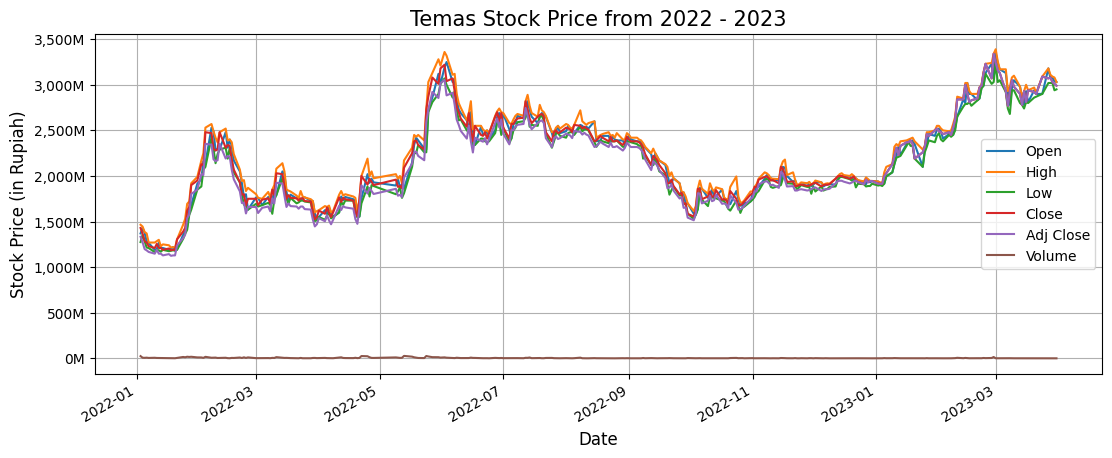

In [6]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize the historical prices from 2022 - 2023
df_tmas['2022':].plot(figsize=(13,5))
plt.title('Temas Stock Price from 2022 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

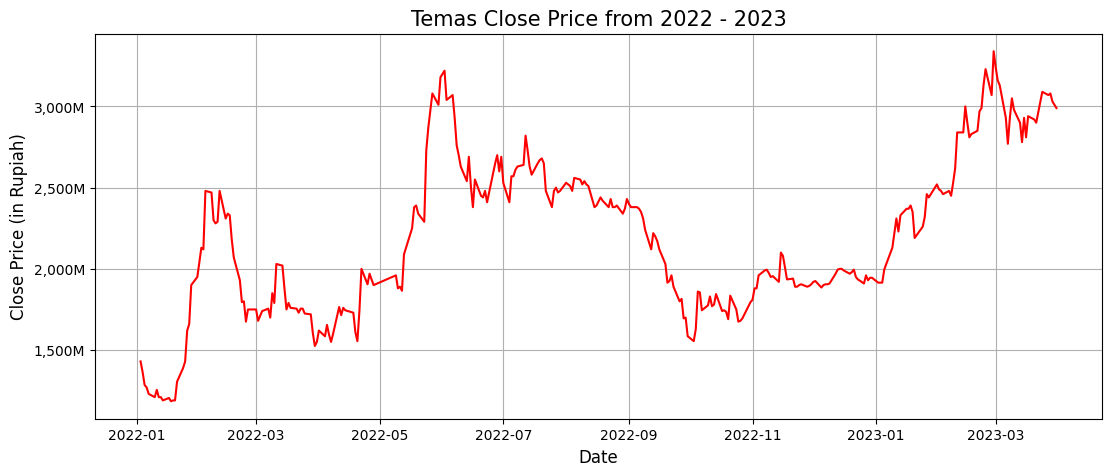

In [7]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize each of price attributes
plt.figure(figsize=(13,5))
plt.plot(df_tmas['Close']['2022':], color='red')
plt.title('Temas Close Price from 2022 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

In [8]:
# Select the close price column as the target variable
target_col = 'Close'

# Create a new dataframe with only the target variable
target_df = pd.DataFrame(df_tmas[target_col])

# Split the data into training and testing sets
train_size = int(len(target_df) * 0.9)
train_df = target_df[:train_size]
test_df = target_df[train_size:]
print('Training Set: ', train_df.shape)
print('Testing Set: ', test_df.shape)

Training Set:  (2682, 1)
Testing Set:  (298, 1)


In [9]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)
print('Training Scaled: ', train_scaled[0:5], '\n')
print('Testing Scaled: ', test_scaled[0:5])

Training Scaled:  [[0.0010805 ]
 [0.00081037]
 [0.00067531]
 [0.00121556]
 [0.00121556]] 

Testing Scaled:  [[0.7906537 ]
 [0.77714749]
 [0.78052404]
 [0.78052404]
 [0.85818476]]


In [10]:
# Define the sequence length and number of features
sequence_length = 60
num_features = 1

# Define the function to create sequences
def create_sequences(X, y, seq_length):
    X_sequences, y_sequences = [], []
    for i in range(seq_length, len(X)):
        X_sequences.append(X[i-seq_length:i, :])
        y_sequences.append(y[i, :])
    return np.array(X_sequences), np.array(y_sequences)

# Create training sequences and labels
X_train, y_train = create_sequences(train_scaled, train_scaled, sequence_length)

# Create testing sequences and labels
X_test, y_test = create_sequences(test_scaled, test_scaled, sequence_length)

# Print the shape of the training and testing sets
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (2622, 60, 1)
y train shape: (2622, 1)
X test shape: (238, 60, 1)
y test shape: (238, 1)


##### LSTM Network Default Model

In [11]:
# define the model
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features)))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error')
# train the model
model.fit(X_train, y_train, epochs=10, 
          batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 4s 56ms/step - loss: 0.0057 - val_loss: 0.0367
Epoch 2/10
24/24 [==============================] - 1s 23ms/step - loss: 4.4575e-04 - val_loss: 0.0141
Epoch 3/10
24/24 [==============================] - 1s 22ms/step - loss: 1.6877e-04 - val_loss: 0.0120
Epoch 4/10
24/24 [==============================] - 1s 23ms/step - loss: 1.6856e-04 - val_loss: 0.0129
Epoch 5/10
24/24 [==============================] - 1s 23ms/step - loss: 1.6597e-04 - val_loss: 0.0105
Epoch 6/10
24/24 [==============================] - 1s 24ms/step - loss: 1.5501e-04 - val_loss: 0.0109
Epoch 7/10
24/24 [==============================] - 1s 25ms/step - loss: 1.2864e-04 - val_loss: 0.0117
Epoch 8/10
24/24 [==============================] - 1s 23ms/step - loss: 1.3226e-04 - val_loss: 0.0100
Epoch 9/10
24/24 [==============================] - 1s 25ms/step - loss: 1.2702e-04 - val_loss: 0.0090
Epoch 10/10
24/24 [==============================] - 1s 23ms/step - loss: 1.1

In [12]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 1s 6ms/step
Mean Absolute Percentage Error (MAPE):  0.38819
Mean Absolute Error (MAE):  0.6248556
Mean Squared Error (MSE):  0.4553622
Root Mean Squared Error (RMSE):  0.67481
R-Squared:  -4.356043


8/8 [==============================] - 0s 7ms/step


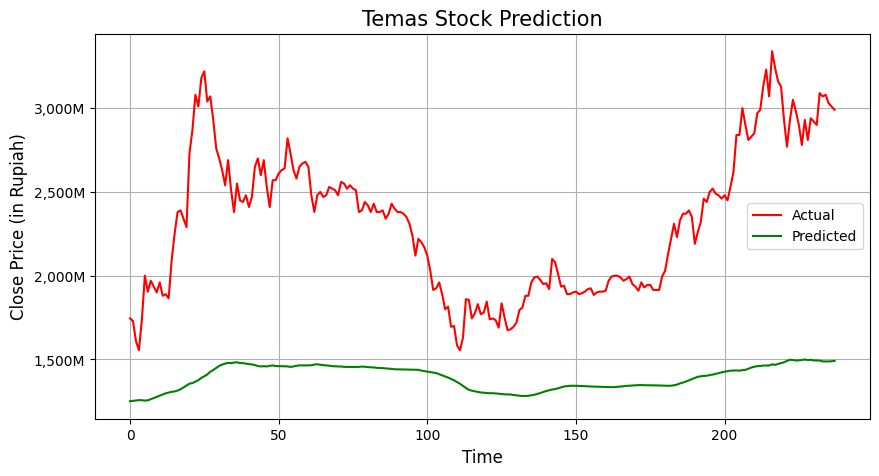

In [13]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

# Save the default model
model.save('models/tmas_lstm_default.h5')

##### Linear - Adam

In [14]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 11s 234ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 2/10
24/24 [==============================] - 6s 240ms/step - loss: 1.9698e-04 - val_loss: 0.0042
Epoch 3/10
24/24 [==============================] - 6s 241ms/step - loss: 1.3984e-04 - val_loss: 0.0044
Epoch 4/10
24/24 [==============================] - 6s 250ms/step - loss: 1.2607e-04 - val_loss: 0.0042
Epoch 5/10
24/24 [==============================] - 6s 245ms/step - loss: 1.2571e-04 - val_loss: 0.0040
Epoch 6/10
24/24 [==============================] - 6s 240ms/step - loss: 1.2902e-04 - val_loss: 0.0035
Epoch 7/10
24/24 [==============================] - 6s 238ms/step - loss: 1.1322e-04 - val_loss: 0.0036
Epoch 8/10
24/24 [==============================] - 6s 247ms/step - loss: 9.3581e-05 - val_loss: 0.0035
Epoch 9/10
24/24 [==============================] - 6s 241ms/step - loss: 8.9908e-05 - val_loss: 0.0035
Epoch 10/10
24/24 [==============================] - 6s 243ms/step 

In [15]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 33ms/step
Mean Absolute Percentage Error (MAPE):  0.07053
Mean Absolute Error (MAE):  0.1145074
Mean Squared Error (MSE):  0.0231505
Root Mean Squared Error (RMSE):  0.15215
R-Squared:  0.727701


8/8 [==============================] - 0s 30ms/step


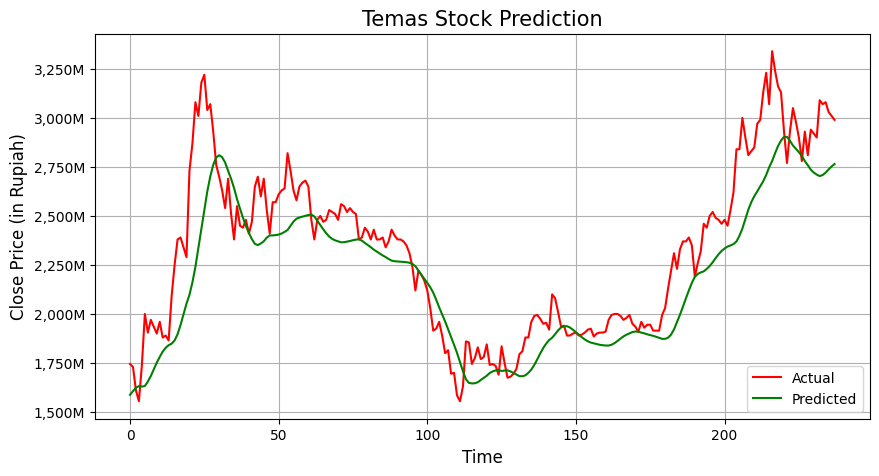

In [16]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

# Save the default model
model.save('models/tmas_linear_adam.h5')

##### Linear - AdaGrad

In [17]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 12s 258ms/step - loss: 0.0097 - val_loss: 0.0856
Epoch 2/10
24/24 [==============================] - 12s 526ms/step - loss: 0.0064 - val_loss: 0.0783
Epoch 3/10
24/24 [==============================] - 13s 552ms/step - loss: 0.0059 - val_loss: 0.0752
Epoch 4/10
24/24 [==============================] - 13s 543ms/step - loss: 0.0058 - val_loss: 0.0739
Epoch 5/10
24/24 [==============================] - 14s 571ms/step - loss: 0.0056 - val_loss: 0.0731
Epoch 6/10
24/24 [==============================] - 14s 569ms/step - loss: 0.0056 - val_loss: 0.0726
Epoch 7/10
24/24 [==============================] - 13s 562ms/step - loss: 0.0056 - val_loss: 0.0719
Epoch 8/10
24/24 [==============================] - 14s 567ms/step - loss: 0.0055 - val_loss: 0.0711
Epoch 9/10
24/24 [==============================] - 13s 555ms/step - loss: 0.0054 - val_loss: 0.0705
Epoch 10/10
24/24 [==============================] - 16s 675ms/step - loss: 0.0054 - val_lo

In [18]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 47ms/step
Mean Absolute Percentage Error (MAPE):  0.86133
Mean Absolute Error (MAE):  1.3333625
Mean Squared Error (MSE):  1.8515418
Root Mean Squared Error (RMSE):  1.36071
R-Squared:  -20.778128


8/8 [==============================] - 0s 48ms/step


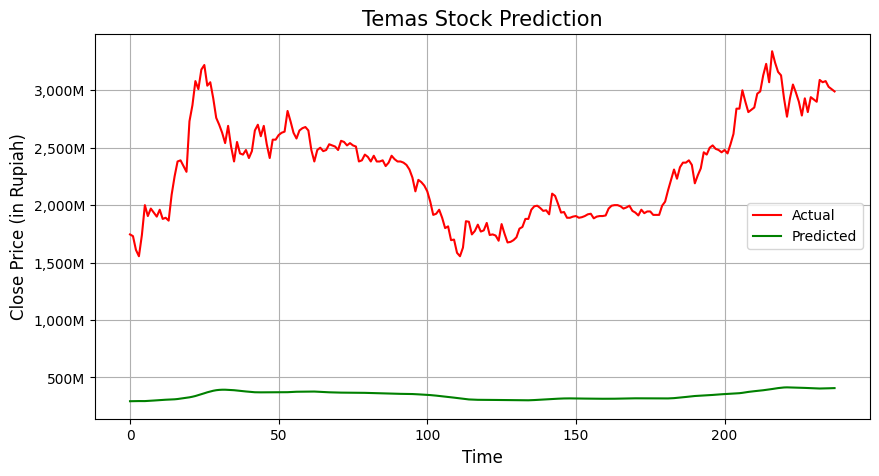

In [19]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_linear_adagrad.h5')

##### Linear - Nadam

In [20]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 28s 687ms/step - loss: 0.0013 - val_loss: 0.0056
Epoch 2/10
24/24 [==============================] - 10s 405ms/step - loss: 1.7996e-04 - val_loss: 0.0046
Epoch 3/10
24/24 [==============================] - 9s 373ms/step - loss: 1.4092e-04 - val_loss: 0.0046
Epoch 4/10
24/24 [==============================] - 11s 445ms/step - loss: 1.4149e-04 - val_loss: 0.0041
Epoch 5/10
24/24 [==============================] - 10s 408ms/step - loss: 1.2331e-04 - val_loss: 0.0037
Epoch 6/10
24/24 [==============================] - 9s 380ms/step - loss: 1.1628e-04 - val_loss: 0.0035
Epoch 7/10
24/24 [==============================] - 9s 379ms/step - loss: 1.0418e-04 - val_loss: 0.0035
Epoch 8/10
24/24 [==============================] - 9s 374ms/step - loss: 1.0265e-04 - val_loss: 0.0036
Epoch 9/10
24/24 [==============================] - 9s 362ms/step - loss: 9.5821e-05 - val_loss: 0.0034
Epoch 10/10
24/24 [==============================] - 9s 367ms/st

In [21]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 32ms/step
Mean Absolute Percentage Error (MAPE):  0.11386
Mean Absolute Error (MAE):  0.1830968
Mean Squared Error (MSE):  0.0461649
Root Mean Squared Error (RMSE):  0.21486
R-Squared:  0.457001


8/8 [==============================] - 0s 32ms/step


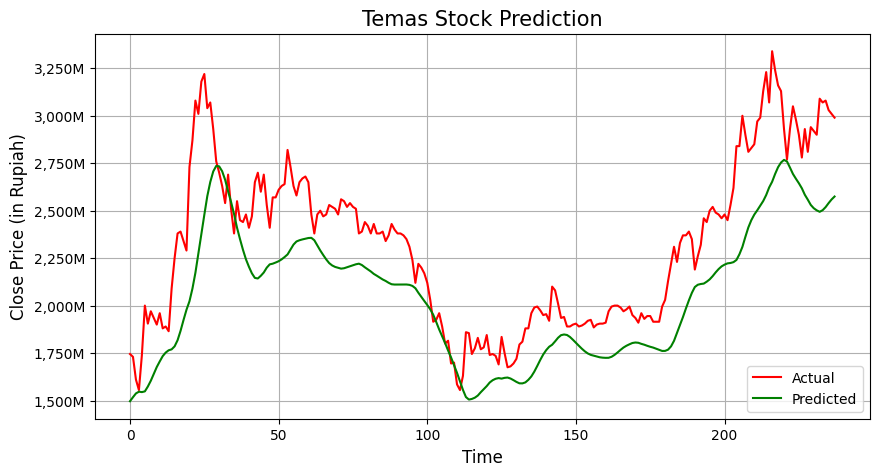

In [22]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_linear_nadam.h5')

#### Linear - RMSProp

In [23]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 16s 435ms/step - loss: 0.0017 - val_loss: 0.0149
Epoch 2/10
24/24 [==============================] - 9s 387ms/step - loss: 6.6957e-04 - val_loss: 0.0122
Epoch 3/10
24/24 [==============================] - 9s 381ms/step - loss: 5.7585e-04 - val_loss: 0.0124
Epoch 4/10
24/24 [==============================] - 9s 361ms/step - loss: 5.2637e-04 - val_loss: 0.0121
Epoch 5/10
24/24 [==============================] - 10s 420ms/step - loss: 4.6490e-04 - val_loss: 0.0101
Epoch 6/10
24/24 [==============================] - 10s 429ms/step - loss: 4.3918e-04 - val_loss: 0.0078
Epoch 7/10
24/24 [==============================] - 10s 433ms/step - loss: 4.1645e-04 - val_loss: 0.0061
Epoch 8/10
24/24 [==============================] - 12s 499ms/step - loss: 4.1941e-04 - val_loss: 0.0068
Epoch 9/10
24/24 [==============================] - 10s 422ms/step - loss: 3.5715e-04 - val_loss: 0.0067
Epoch 10/10
24/24 [==============================] - 11s 439ms

In [24]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 53ms/step
Mean Absolute Percentage Error (MAPE):  0.18008
Mean Absolute Error (MAE):  0.2949111
Mean Squared Error (MSE):  0.1152141
Root Mean Squared Error (RMSE):  0.33943
R-Squared:  -0.355166


8/8 [==============================] - 0s 38ms/step


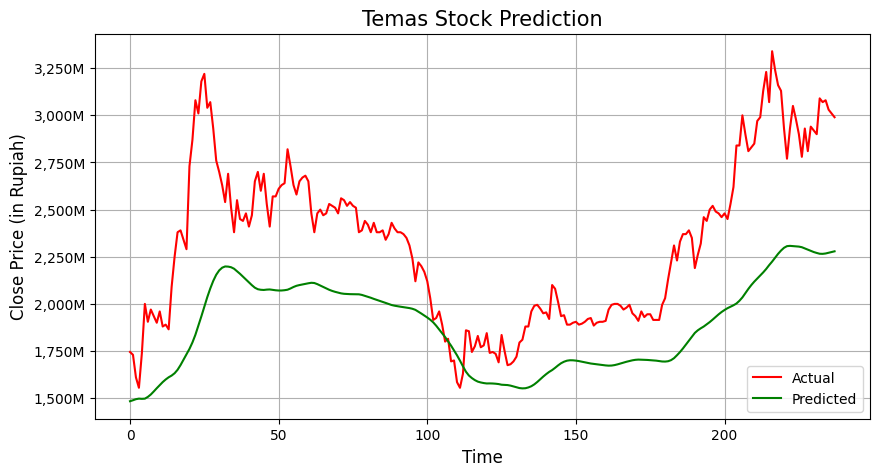

In [25]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_linear_rmsprop.h5')

##### Linear - AdaDelta

In [26]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 24s 610ms/step - loss: 0.0142 - val_loss: 0.1049
Epoch 2/10
24/24 [==============================] - 11s 460ms/step - loss: 0.0138 - val_loss: 0.1040
Epoch 3/10
24/24 [==============================] - 11s 478ms/step - loss: 0.0135 - val_loss: 0.1030
Epoch 4/10
24/24 [==============================] - 12s 494ms/step - loss: 0.0133 - val_loss: 0.1021
Epoch 5/10
24/24 [==============================] - 11s 465ms/step - loss: 0.0130 - val_loss: 0.1012
Epoch 6/10
24/24 [==============================] - 11s 470ms/step - loss: 0.0127 - val_loss: 0.1003
Epoch 7/10
24/24 [==============================] - 11s 472ms/step - loss: 0.0125 - val_loss: 0.0993
Epoch 8/10
24/24 [==============================] - 11s 469ms/step - loss: 0.0122 - val_loss: 0.0984
Epoch 9/10
24/24 [==============================] - 11s 457ms/step - loss: 0.0119 - val_loss: 0.0975
Epoch 10/10
24/24 [==============================] - 11s 475ms/step - loss: 0.0117 - val_lo

In [27]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Percentage Error (MAPE):  0.91242
Mean Absolute Error (MAE):  1.409388
Mean Squared Error (MSE):  2.059897
Root Mean Squared Error (RMSE):  1.43523
R-Squared:  -23.228835


8/8 [==============================] - 0s 44ms/step


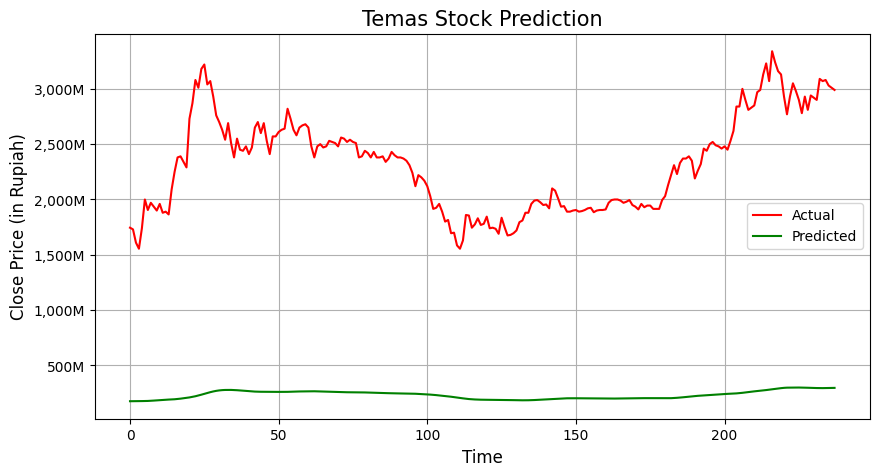

In [28]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_linear_adadelta.h5')

##### Linear - SGD

In [29]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 18s 449ms/step - loss: 0.0058 - val_loss: 0.0612
Epoch 2/10
24/24 [==============================] - 9s 383ms/step - loss: 0.0045 - val_loss: 0.0598
Epoch 3/10
24/24 [==============================] - 9s 393ms/step - loss: 0.0043 - val_loss: 0.0591
Epoch 4/10
24/24 [==============================] - 10s 404ms/step - loss: 0.0042 - val_loss: 0.0568
Epoch 5/10
24/24 [==============================] - 9s 394ms/step - loss: 0.0041 - val_loss: 0.0564
Epoch 6/10
24/24 [==============================] - 9s 385ms/step - loss: 0.0040 - val_loss: 0.0552
Epoch 7/10
24/24 [==============================] - 9s 389ms/step - loss: 0.0038 - val_loss: 0.0538
Epoch 8/10
24/24 [==============================] - 9s 379ms/step - loss: 0.0037 - val_loss: 0.0526
Epoch 9/10
24/24 [==============================] - 9s 376ms/step - loss: 0.0036 - val_loss: 0.0507
Epoch 10/10
24/24 [==============================] - 10s 399ms/step - loss: 0.0035 - val_loss: 0.0

In [30]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 45ms/step
Mean Absolute Percentage Error (MAPE):  0.71775
Mean Absolute Error (MAE):  1.1148973
Mean Squared Error (MSE):  1.3047493
Root Mean Squared Error (RMSE):  1.14226
R-Squared:  -14.346669


8/8 [==============================] - 0s 44ms/step


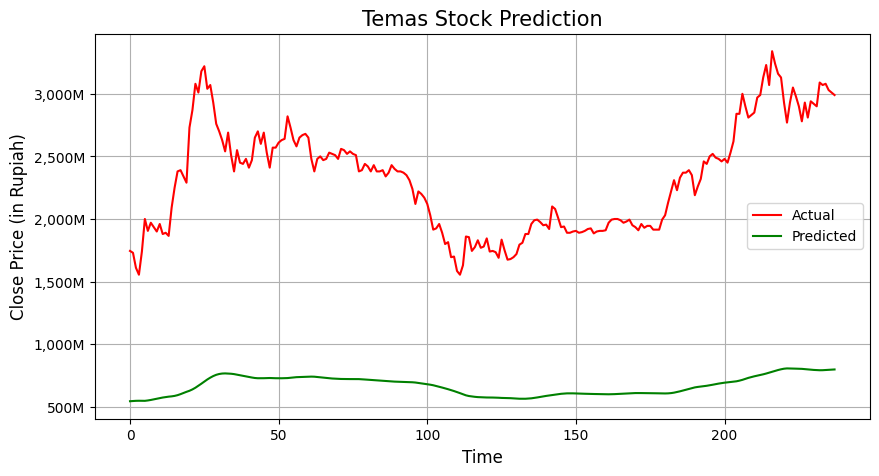

In [31]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_linear_sgd.h5')

#### Linear - Adamax

In [32]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 22s 559ms/step - loss: 0.0016 - val_loss: 0.0065
Epoch 2/10
24/24 [==============================] - 10s 429ms/step - loss: 2.2650e-04 - val_loss: 0.0073
Epoch 3/10
24/24 [==============================] - 10s 425ms/step - loss: 2.0374e-04 - val_loss: 0.0063
Epoch 4/10
24/24 [==============================] - 11s 479ms/step - loss: 1.8130e-04 - val_loss: 0.0063
Epoch 5/10
24/24 [==============================] - 11s 460ms/step - loss: 1.7767e-04 - val_loss: 0.0060
Epoch 6/10
24/24 [==============================] - 11s 473ms/step - loss: 1.5511e-04 - val_loss: 0.0062
Epoch 7/10
24/24 [==============================] - 11s 463ms/step - loss: 1.7509e-04 - val_loss: 0.0060
Epoch 8/10
24/24 [==============================] - 12s 494ms/step - loss: 1.7028e-04 - val_loss: 0.0056
Epoch 9/10
24/24 [==============================] - 10s 430ms/step - loss: 1.4746e-04 - val_loss: 0.0059
Epoch 10/10
24/24 [==============================] - 11s 44

In [33]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 44ms/step
Mean Absolute Percentage Error (MAPE):  0.08618
Mean Absolute Error (MAE):  0.1414665
Mean Squared Error (MSE):  0.0361378
Root Mean Squared Error (RMSE):  0.1901
R-Squared:  0.574942


8/8 [==============================] - 0s 40ms/step


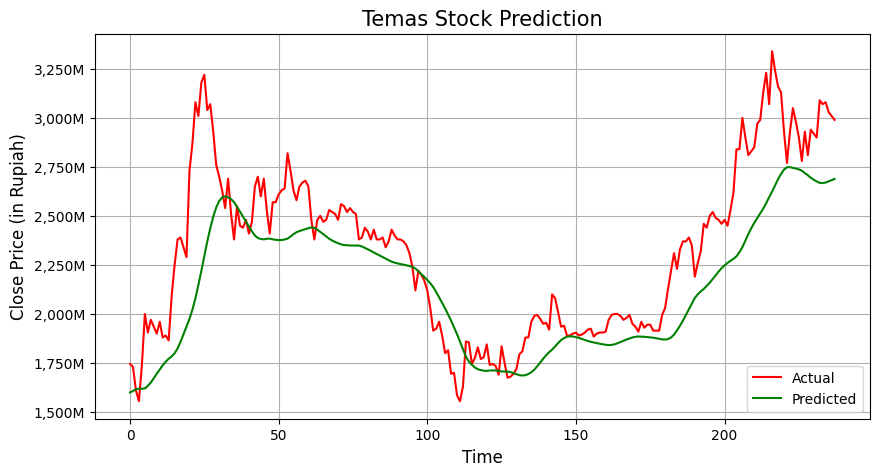

In [34]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_linear_adamax.h5')

##### ReLU - Adam

In [35]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 23s 633ms/step - loss: 0.0026 - val_loss: 0.0076
Epoch 2/10
24/24 [==============================] - 12s 508ms/step - loss: 2.2633e-04 - val_loss: 0.0060
Epoch 3/10
24/24 [==============================] - 13s 534ms/step - loss: 1.6979e-04 - val_loss: 0.0052
Epoch 4/10
24/24 [==============================] - 13s 553ms/step - loss: 1.4022e-04 - val_loss: 0.0051
Epoch 5/10
24/24 [==============================] - 13s 561ms/step - loss: 1.3232e-04 - val_loss: 0.0049
Epoch 6/10
24/24 [==============================] - 13s 536ms/step - loss: 1.3472e-04 - val_loss: 0.0046
Epoch 7/10
24/24 [==============================] - 13s 537ms/step - loss: 1.2431e-04 - val_loss: 0.0042
Epoch 8/10
24/24 [==============================] - 13s 545ms/step - loss: 1.1800e-04 - val_loss: 0.0038
Epoch 9/10
24/24 [==============================] - 13s 540ms/step - loss: 1.1418e-04 - val_loss: 0.0038
Epoch 10/10
24/24 [==============================] - 14s 57

In [36]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 50ms/step
Mean Absolute Percentage Error (MAPE):  0.07976
Mean Absolute Error (MAE):  0.1303226
Mean Squared Error (MSE):  0.0292544
Root Mean Squared Error (RMSE):  0.17104
R-Squared:  0.655905


8/8 [==============================] - 0s 49ms/step


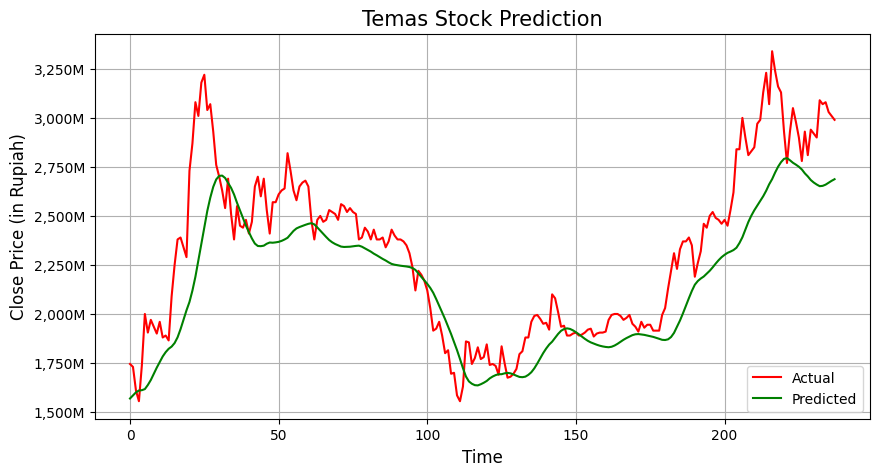

In [37]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_relu_adam.h5')

#### ReLU - AdaGrad

In [38]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 18s 473ms/step - loss: 0.0138 - val_loss: 0.1082
Epoch 2/10
24/24 [==============================] - 9s 374ms/step - loss: 0.0105 - val_loss: 0.1004
Epoch 3/10
24/24 [==============================] - 10s 410ms/step - loss: 0.0086 - val_loss: 0.0950
Epoch 4/10
24/24 [==============================] - 12s 484ms/step - loss: 0.0073 - val_loss: 0.0908
Epoch 5/10
24/24 [==============================] - 10s 423ms/step - loss: 0.0064 - val_loss: 0.0875
Epoch 6/10
24/24 [==============================] - 10s 414ms/step - loss: 0.0057 - val_loss: 0.0847
Epoch 7/10
24/24 [==============================] - 10s 425ms/step - loss: 0.0053 - val_loss: 0.0825
Epoch 8/10
24/24 [==============================] - 9s 387ms/step - loss: 0.0049 - val_loss: 0.0805
Epoch 9/10
24/24 [==============================] - 10s 403ms/step - loss: 0.0046 - val_loss: 0.0789
Epoch 10/10
24/24 [==============================] - 10s 437ms/step - loss: 0.0044 - val_loss

In [39]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 37ms/step
Mean Absolute Percentage Error (MAPE):  0.94275
Mean Absolute Error (MAE):  1.4588983
Mean Squared Error (MSE):  2.2147284
Root Mean Squared Error (RMSE):  1.4882
R-Squared:  -25.049987


8/8 [==============================] - 0s 43ms/step


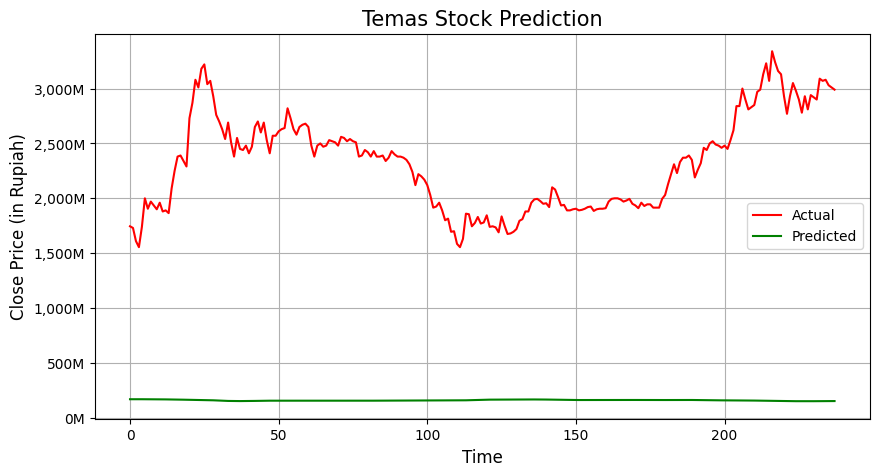

In [40]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_relu_adagrad.h5')

##### ReLU - Nadam

In [41]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 21s 485ms/step - loss: 0.0016 - val_loss: 0.0069
Epoch 2/10
24/24 [==============================] - 11s 442ms/step - loss: 2.2051e-04 - val_loss: 0.0070
Epoch 3/10
24/24 [==============================] - 11s 454ms/step - loss: 1.8305e-04 - val_loss: 0.0061
Epoch 4/10
24/24 [==============================] - 11s 463ms/step - loss: 1.4804e-04 - val_loss: 0.0051
Epoch 5/10
24/24 [==============================] - 11s 461ms/step - loss: 1.4192e-04 - val_loss: 0.0059
Epoch 6/10
24/24 [==============================] - 11s 441ms/step - loss: 1.2390e-04 - val_loss: 0.0050
Epoch 7/10
24/24 [==============================] - 11s 452ms/step - loss: 1.1502e-04 - val_loss: 0.0056
Epoch 8/10
24/24 [==============================] - 11s 453ms/step - loss: 1.2524e-04 - val_loss: 0.0044
Epoch 9/10
24/24 [==============================] - 11s 436ms/step - loss: 1.0192e-04 - val_loss: 0.0045
Epoch 10/10
24/24 [==============================] - 11s 44

In [42]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 37ms/step
Mean Absolute Percentage Error (MAPE):  0.17678
Mean Absolute Error (MAE):  0.2833885
Mean Squared Error (MSE):  0.0989497
Root Mean Squared Error (RMSE):  0.31456
R-Squared:  -0.163862


8/8 [==============================] - 0s 42ms/step


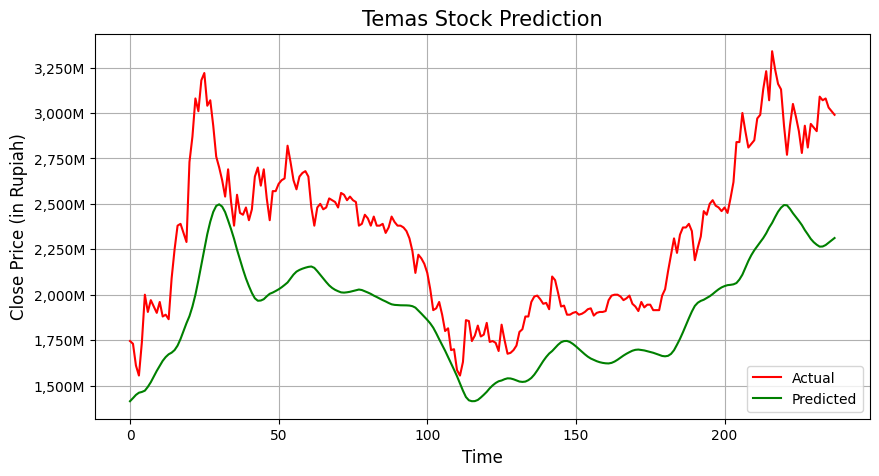

In [43]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_relu_nadam.h5')

##### ReLU - RMSProp

In [44]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 19s 506ms/step - loss: 0.0028 - val_loss: 0.0093
Epoch 2/10
24/24 [==============================] - 10s 437ms/step - loss: 5.8334e-04 - val_loss: 0.0153
Epoch 3/10
24/24 [==============================] - 11s 470ms/step - loss: 5.0900e-04 - val_loss: 0.0148
Epoch 4/10
24/24 [==============================] - 12s 495ms/step - loss: 4.2906e-04 - val_loss: 0.0087
Epoch 5/10
24/24 [==============================] - 14s 591ms/step - loss: 3.8839e-04 - val_loss: 0.0081
Epoch 6/10
24/24 [==============================] - 11s 459ms/step - loss: 3.6600e-04 - val_loss: 0.0071
Epoch 7/10
24/24 [==============================] - 11s 438ms/step - loss: 3.2179e-04 - val_loss: 0.0126
Epoch 8/10
24/24 [==============================] - 11s 442ms/step - loss: 3.3290e-04 - val_loss: 0.0102
Epoch 9/10
24/24 [==============================] - 11s 444ms/step - loss: 3.2726e-04 - val_loss: 0.0089
Epoch 10/10
24/24 [==============================] - 11s 46

In [45]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Percentage Error (MAPE):  0.24613
Mean Absolute Error (MAE):  0.4015626
Mean Squared Error (MSE):  0.2015401
Root Mean Squared Error (RMSE):  0.44893
R-Squared:  -1.370546


8/8 [==============================] - 0s 41ms/step


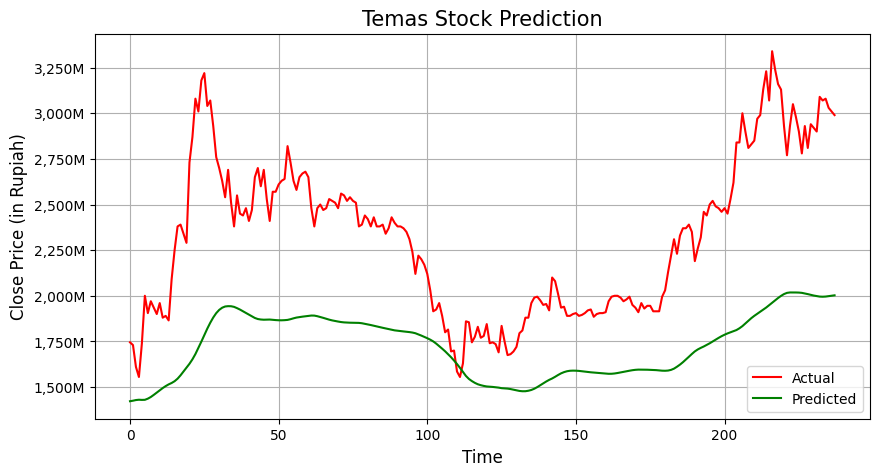

In [46]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_relu_rmsprop.h5')

##### ReLU - AdaDelta

In [47]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 18s 469ms/step - loss: 0.0133 - val_loss: 0.1009
Epoch 2/10
24/24 [==============================] - 9s 396ms/step - loss: 0.0132 - val_loss: 0.1004
Epoch 3/10
24/24 [==============================] - 10s 403ms/step - loss: 0.0129 - val_loss: 0.0999
Epoch 4/10
24/24 [==============================] - 10s 421ms/step - loss: 0.0128 - val_loss: 0.0993
Epoch 5/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0127 - val_loss: 0.0988
Epoch 6/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0124 - val_loss: 0.0983
Epoch 7/10
24/24 [==============================] - 10s 429ms/step - loss: 0.0123 - val_loss: 0.0977
Epoch 8/10
24/24 [==============================] - 10s 409ms/step - loss: 0.0121 - val_loss: 0.0972
Epoch 9/10
24/24 [==============================] - 10s 406ms/step - loss: 0.0119 - val_loss: 0.0966
Epoch 10/10
24/24 [==============================] - 10s 408ms/step - loss: 0.0118 - val_los

In [48]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Percentage Error (MAPE):  0.91471
Mean Absolute Error (MAE):  1.412994
Mean Squared Error (MSE):  2.0705384
Root Mean Squared Error (RMSE):  1.43894
R-Squared:  -23.354001


8/8 [==============================] - 0s 42ms/step


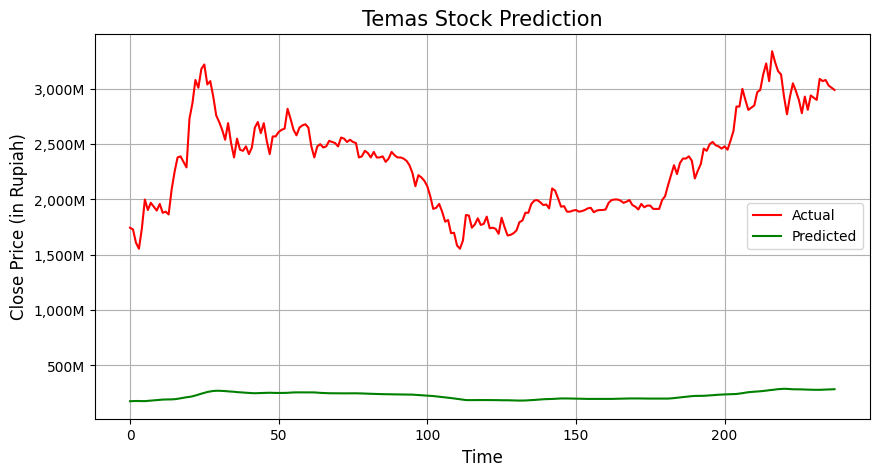

In [49]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_relu_adadelta.h5')

##### ReLU - SGD

In [50]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 14s 372ms/step - loss: 0.0091 - val_loss: 0.0848
Epoch 2/10
24/24 [==============================] - 8s 323ms/step - loss: 0.0060 - val_loss: 0.0790
Epoch 3/10
24/24 [==============================] - 8s 347ms/step - loss: 0.0057 - val_loss: 0.0768
Epoch 4/10
24/24 [==============================] - 8s 341ms/step - loss: 0.0055 - val_loss: 0.0754
Epoch 5/10
24/24 [==============================] - 9s 379ms/step - loss: 0.0053 - val_loss: 0.0735
Epoch 6/10
24/24 [==============================] - 10s 395ms/step - loss: 0.0052 - val_loss: 0.0724
Epoch 7/10
24/24 [==============================] - 8s 352ms/step - loss: 0.0051 - val_loss: 0.0710
Epoch 8/10
24/24 [==============================] - 8s 329ms/step - loss: 0.0049 - val_loss: 0.0700
Epoch 9/10
24/24 [==============================] - 9s 359ms/step - loss: 0.0048 - val_loss: 0.0691
Epoch 10/10
24/24 [==============================] - 8s 353ms/step - loss: 0.0048 - val_loss: 0.06

In [51]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Percentage Error (MAPE):  0.87189
Mean Absolute Error (MAE):  1.3518683
Mean Squared Error (MSE):  1.9094888
Root Mean Squared Error (RMSE):  1.38184
R-Squared:  -21.45971


8/8 [==============================] - 0s 52ms/step


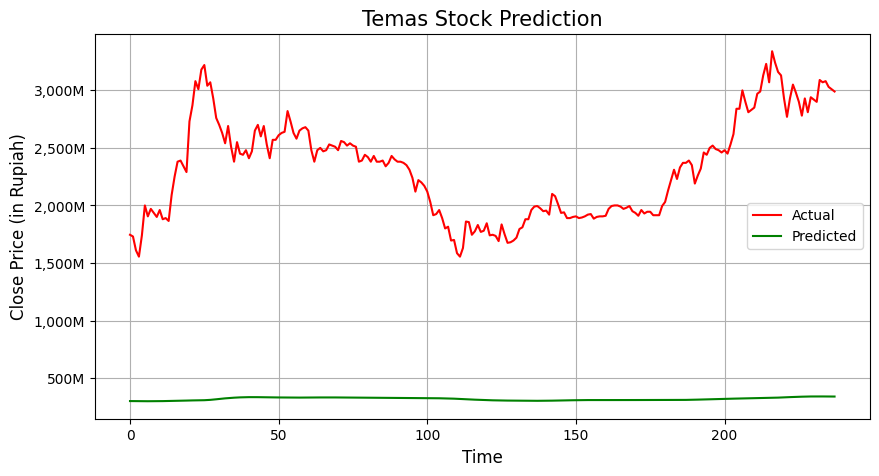

In [52]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_relu_sgd.h5')

##### ReLU - Adamax

In [53]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 17s 384ms/step - loss: 0.0017 - val_loss: 0.0081
Epoch 2/10
24/24 [==============================] - 7s 313ms/step - loss: 3.3434e-04 - val_loss: 0.0089
Epoch 3/10
24/24 [==============================] - 7s 272ms/step - loss: 2.6911e-04 - val_loss: 0.0076
Epoch 4/10
24/24 [==============================] - 6s 245ms/step - loss: 2.3774e-04 - val_loss: 0.0072
Epoch 5/10
24/24 [==============================] - 6s 255ms/step - loss: 2.2232e-04 - val_loss: 0.0075
Epoch 6/10
24/24 [==============================] - 6s 261ms/step - loss: 2.2232e-04 - val_loss: 0.0076
Epoch 7/10
24/24 [==============================] - 7s 286ms/step - loss: 1.8713e-04 - val_loss: 0.0072
Epoch 8/10
24/24 [==============================] - 7s 281ms/step - loss: 1.9030e-04 - val_loss: 0.0068
Epoch 9/10
24/24 [==============================] - 7s 272ms/step - loss: 1.8192e-04 - val_loss: 0.0066
Epoch 10/10
24/24 [==============================] - 6s 259ms/step 

In [54]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 35ms/step
Mean Absolute Percentage Error (MAPE):  0.07048
Mean Absolute Error (MAE):  0.1142348
Mean Squared Error (MSE):  0.0270512
Root Mean Squared Error (RMSE):  0.16447
R-Squared:  0.68182


8/8 [==============================] - 0s 37ms/step


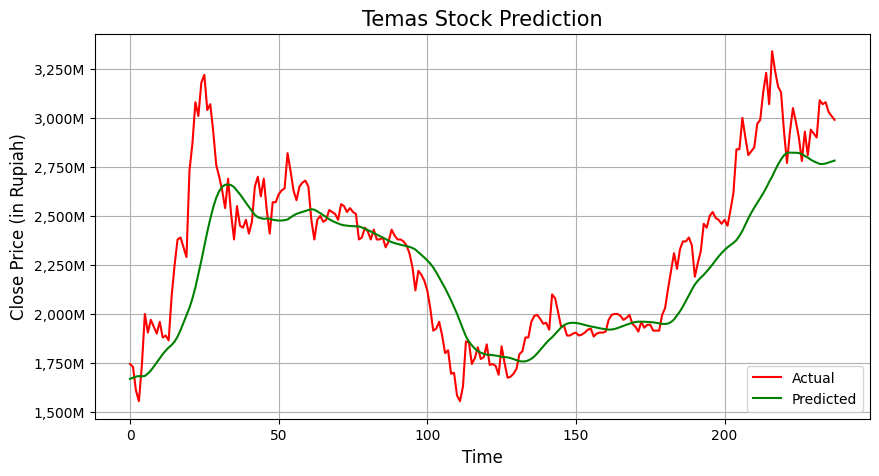

In [55]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_relu_adamax.h5')

##### Sigmoid - Adam

In [56]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 16s 323ms/step - loss: 0.0018 - val_loss: 0.0095
Epoch 2/10
24/24 [==============================] - 6s 248ms/step - loss: 2.1635e-04 - val_loss: 0.0064
Epoch 3/10
24/24 [==============================] - 6s 264ms/step - loss: 1.6258e-04 - val_loss: 0.0081
Epoch 4/10
24/24 [==============================] - 7s 274ms/step - loss: 1.4647e-04 - val_loss: 0.0058
Epoch 5/10
24/24 [==============================] - 6s 267ms/step - loss: 1.2787e-04 - val_loss: 0.0052
Epoch 6/10
24/24 [==============================] - 7s 282ms/step - loss: 1.1383e-04 - val_loss: 0.0054
Epoch 7/10
24/24 [==============================] - 7s 272ms/step - loss: 1.1748e-04 - val_loss: 0.0059
Epoch 8/10
24/24 [==============================] - 7s 279ms/step - loss: 1.0537e-04 - val_loss: 0.0054
Epoch 9/10
24/24 [==============================] - 6s 258ms/step - loss: 1.0422e-04 - val_loss: 0.0047
Epoch 10/10
24/24 [==============================] - 6s 260ms/step 

In [57]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 43ms/step
Mean Absolute Percentage Error (MAPE):  0.26767
Mean Absolute Error (MAE):  0.4315401
Mean Squared Error (MSE):  0.221088
Root Mean Squared Error (RMSE):  0.4702
R-Squared:  -1.600472


8/8 [==============================] - 0s 36ms/step


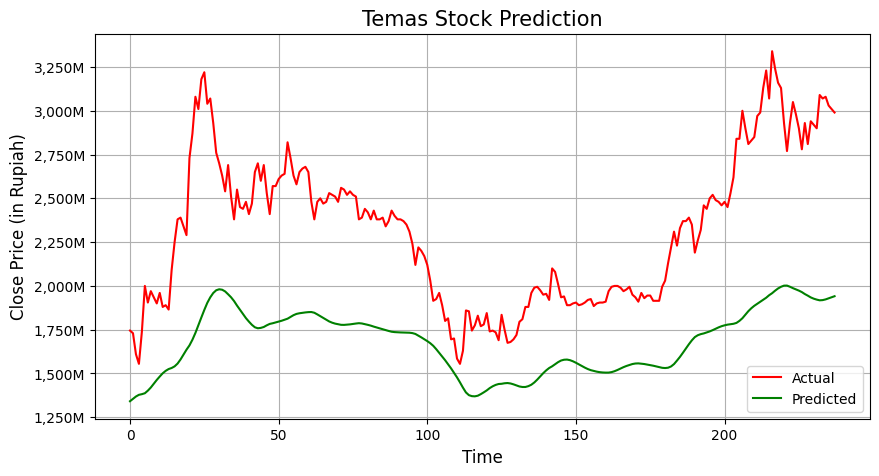

In [58]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_sigmoid_adam.h5')

##### Sigmoid - AdaGrad

In [59]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 14s 342ms/step - loss: 0.2754 - val_loss: 0.4101
Epoch 2/10
24/24 [==============================] - 7s 280ms/step - loss: 0.1824 - val_loss: 0.3304
Epoch 3/10
24/24 [==============================] - 7s 298ms/step - loss: 0.1348 - val_loss: 0.2787
Epoch 4/10
24/24 [==============================] - 7s 299ms/step - loss: 0.1034 - val_loss: 0.2413
Epoch 5/10
24/24 [==============================] - 8s 346ms/step - loss: 0.0813 - val_loss: 0.2127
Epoch 6/10
24/24 [==============================] - 8s 336ms/step - loss: 0.0647 - val_loss: 0.1903
Epoch 7/10
24/24 [==============================] - 8s 319ms/step - loss: 0.0522 - val_loss: 0.1723
Epoch 8/10
24/24 [==============================] - 8s 319ms/step - loss: 0.0425 - val_loss: 0.1577
Epoch 9/10
24/24 [==============================] - 7s 303ms/step - loss: 0.0349 - val_loss: 0.1456
Epoch 10/10
24/24 [==============================] - 8s 332ms/step - loss: 0.0290 - val_loss: 0.135

In [60]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 54ms/step
Mean Absolute Percentage Error (MAPE):  1.0072
Mean Absolute Error (MAE):  1.5535118
Mean Squared Error (MSE):  2.4954711
Root Mean Squared Error (RMSE):  1.57971
R-Squared:  -28.352126


8/8 [==============================] - 0s 49ms/step


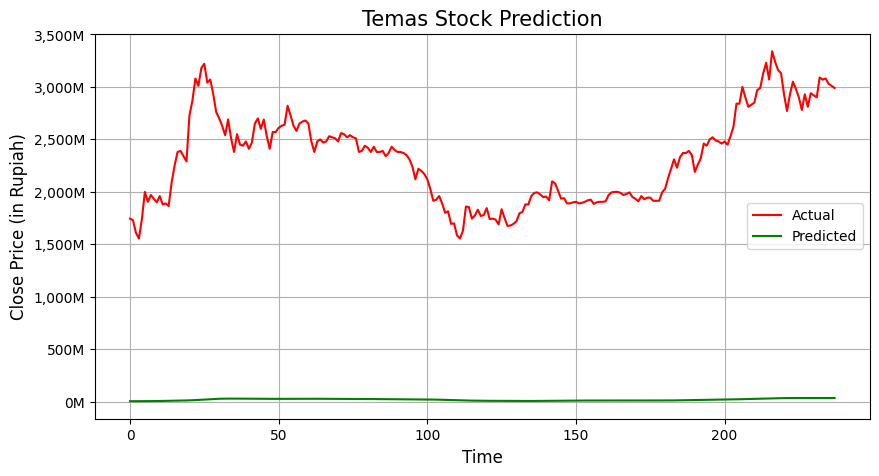

In [61]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_sigmoid_adagrad.h5')

##### Sigmoid - Nadam

In [62]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 378ms/step - loss: 0.0023 - val_loss: 0.0128
Epoch 2/10
24/24 [==============================] - 7s 301ms/step - loss: 1.9490e-04 - val_loss: 0.0130
Epoch 3/10
24/24 [==============================] - 7s 308ms/step - loss: 1.5949e-04 - val_loss: 0.0110
Epoch 4/10
24/24 [==============================] - 7s 293ms/step - loss: 1.3757e-04 - val_loss: 0.0088
Epoch 5/10
24/24 [==============================] - 9s 383ms/step - loss: 1.3020e-04 - val_loss: 0.0083
Epoch 6/10
24/24 [==============================] - 10s 436ms/step - loss: 1.2061e-04 - val_loss: 0.0068
Epoch 7/10
24/24 [==============================] - 8s 328ms/step - loss: 1.1729e-04 - val_loss: 0.0066
Epoch 8/10
24/24 [==============================] - 9s 374ms/step - loss: 1.0905e-04 - val_loss: 0.0068
Epoch 9/10
24/24 [==============================] - 7s 295ms/step - loss: 1.0227e-04 - val_loss: 0.0058
Epoch 10/10
24/24 [==============================] - 7s 295ms/step

In [63]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 52ms/step
Mean Absolute Percentage Error (MAPE):  0.29655
Mean Absolute Error (MAE):  0.4748295
Mean Squared Error (MSE):  0.2615524
Root Mean Squared Error (RMSE):  0.51142
R-Squared:  -2.076421


8/8 [==============================] - 0s 42ms/step


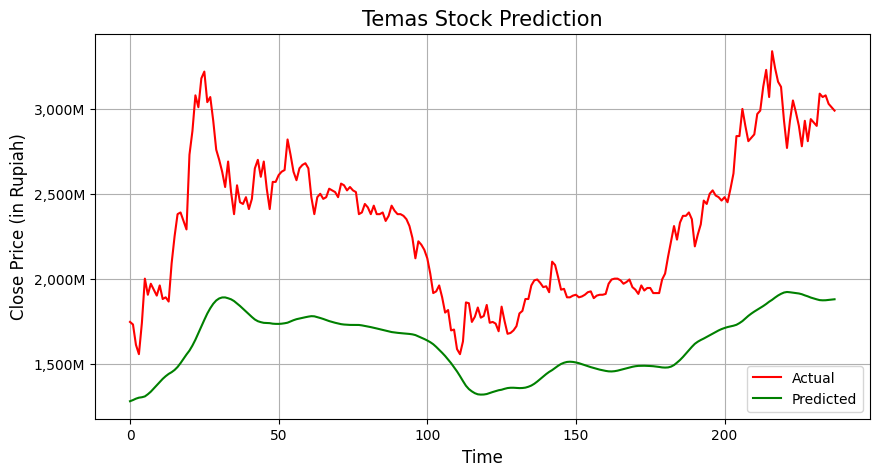

In [64]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_sigmoid_nadam.h5')

##### Sigmoid - RMSProp

In [65]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 435ms/step - loss: 0.1661 - val_loss: 0.0774
Epoch 2/10
24/24 [==============================] - 8s 326ms/step - loss: 0.0137 - val_loss: 0.0935
Epoch 3/10
24/24 [==============================] - 7s 304ms/step - loss: 0.0129 - val_loss: 0.0692
Epoch 4/10
24/24 [==============================] - 8s 341ms/step - loss: 0.0124 - val_loss: 0.0708
Epoch 5/10
24/24 [==============================] - 9s 369ms/step - loss: 0.0104 - val_loss: 0.0687
Epoch 6/10
24/24 [==============================] - 11s 454ms/step - loss: 0.0071 - val_loss: 0.0596
Epoch 7/10
24/24 [==============================] - 8s 353ms/step - loss: 0.0071 - val_loss: 0.0671
Epoch 8/10
24/24 [==============================] - 8s 345ms/step - loss: 0.0054 - val_loss: 0.0600
Epoch 9/10
24/24 [==============================] - 9s 367ms/step - loss: 0.0054 - val_loss: 0.0581
Epoch 10/10
24/24 [==============================] - 8s 331ms/step - loss: 0.0047 - val_loss: 0.05

In [66]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 49ms/step
Mean Absolute Percentage Error (MAPE):  0.82213
Mean Absolute Error (MAE):  1.2783721
Mean Squared Error (MSE):  1.7180504
Root Mean Squared Error (RMSE):  1.31074
R-Squared:  -19.207981


8/8 [==============================] - 0s 57ms/step


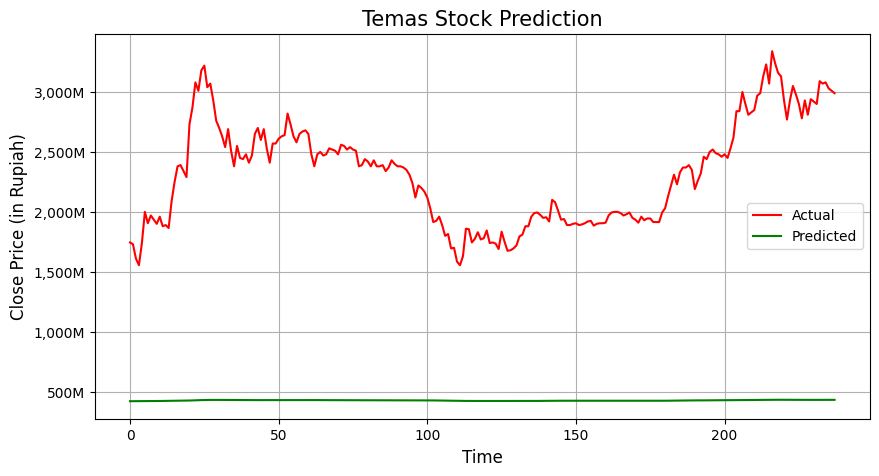

In [67]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_sigmoid_rmsprop.h5')

##### Sigmoid - AdaDelta

In [68]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 22s 502ms/step - loss: 0.0568 - val_loss: 0.0687
Epoch 2/10
24/24 [==============================] - 7s 276ms/step - loss: 0.0564 - val_loss: 0.0685
Epoch 3/10
24/24 [==============================] - 7s 272ms/step - loss: 0.0559 - val_loss: 0.0684
Epoch 4/10
24/24 [==============================] - 7s 278ms/step - loss: 0.0555 - val_loss: 0.0683
Epoch 5/10
24/24 [==============================] - 7s 294ms/step - loss: 0.0551 - val_loss: 0.0682
Epoch 6/10
24/24 [==============================] - 7s 287ms/step - loss: 0.0547 - val_loss: 0.0680
Epoch 7/10
24/24 [==============================] - 7s 288ms/step - loss: 0.0543 - val_loss: 0.0679
Epoch 8/10
24/24 [==============================] - 7s 303ms/step - loss: 0.0539 - val_loss: 0.0678
Epoch 9/10
24/24 [==============================] - 9s 386ms/step - loss: 0.0534 - val_loss: 0.0676
Epoch 10/10
24/24 [==============================] - 7s 294ms/step - loss: 0.0529 - val_loss: 0.067

In [69]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 61ms/step
Mean Absolute Percentage Error (MAPE):  0.80763
Mean Absolute Error (MAE):  1.2578294
Mean Squared Error (MSE):  1.6691874
Root Mean Squared Error (RMSE):  1.29197
R-Squared:  -18.633247


8/8 [==============================] - 0s 47ms/step


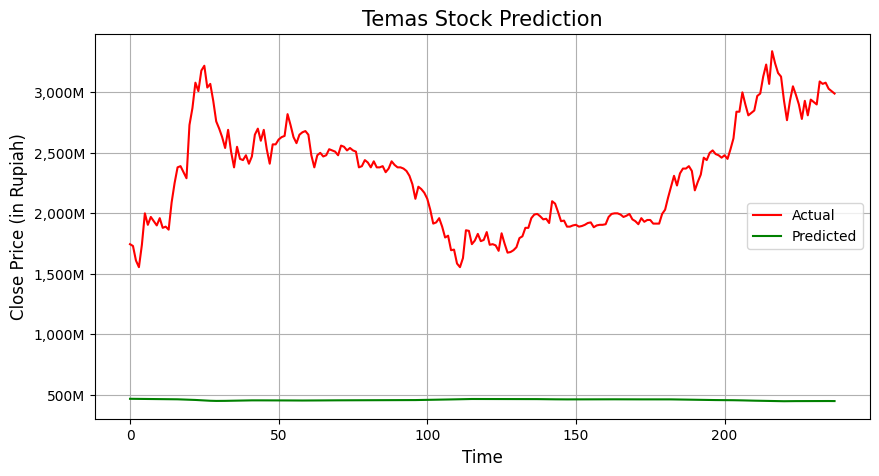

In [70]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_sigmoid_adadelta.h5')

##### Sigmoid - SGD

In [71]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 18s 386ms/step - loss: 0.0395 - val_loss: 0.0767
Epoch 2/10
24/24 [==============================] - 7s 300ms/step - loss: 0.0058 - val_loss: 0.0758
Epoch 3/10
24/24 [==============================] - 7s 288ms/step - loss: 0.0058 - val_loss: 0.0752
Epoch 4/10
24/24 [==============================] - 7s 280ms/step - loss: 0.0058 - val_loss: 0.0756
Epoch 5/10
24/24 [==============================] - 7s 275ms/step - loss: 0.0058 - val_loss: 0.0752
Epoch 6/10
24/24 [==============================] - 7s 289ms/step - loss: 0.0058 - val_loss: 0.0747
Epoch 7/10
24/24 [==============================] - 7s 299ms/step - loss: 0.0058 - val_loss: 0.0759
Epoch 8/10
24/24 [==============================] - 7s 293ms/step - loss: 0.0057 - val_loss: 0.0745
Epoch 9/10
24/24 [==============================] - 7s 311ms/step - loss: 0.0057 - val_loss: 0.0749
Epoch 10/10
24/24 [==============================] - 8s 344ms/step - loss: 0.0057 - val_loss: 0.074

In [72]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 49ms/step
Mean Absolute Percentage Error (MAPE):  0.90374
Mean Absolute Error (MAE):  1.3990175
Mean Squared Error (MSE):  2.038213
Root Mean Squared Error (RMSE):  1.42766
R-Squared:  -22.973785


8/8 [==============================] - 0s 55ms/step


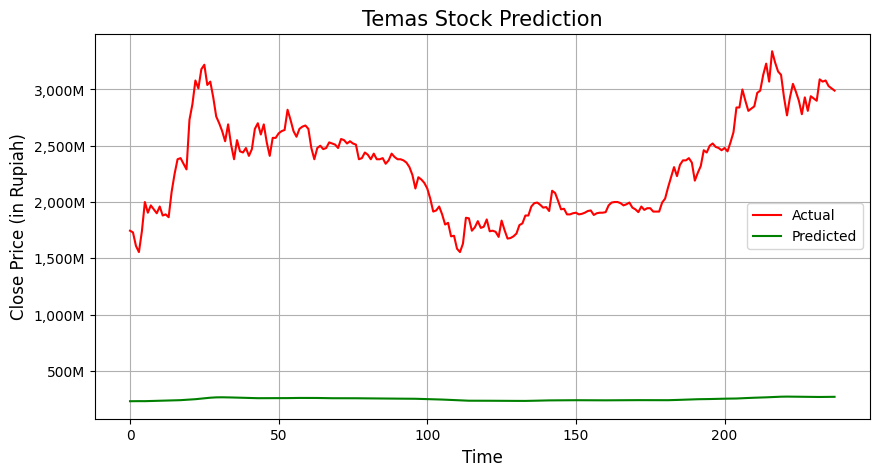

In [73]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_sigmoid_sgd.h5')

##### Sigmoid - Adamax

In [74]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 16s 335ms/step - loss: 0.0359 - val_loss: 0.0967
Epoch 2/10
24/24 [==============================] - 7s 279ms/step - loss: 0.0079 - val_loss: 0.0681
Epoch 3/10
24/24 [==============================] - 6s 257ms/step - loss: 0.0020 - val_loss: 0.0343
Epoch 4/10
24/24 [==============================] - 6s 260ms/step - loss: 5.4249e-04 - val_loss: 0.0293
Epoch 5/10
24/24 [==============================] - 6s 268ms/step - loss: 4.2580e-04 - val_loss: 0.0290
Epoch 6/10
24/24 [==============================] - 7s 280ms/step - loss: 4.0066e-04 - val_loss: 0.0279
Epoch 7/10
24/24 [==============================] - 7s 307ms/step - loss: 3.6966e-04 - val_loss: 0.0267
Epoch 8/10
24/24 [==============================] - 7s 294ms/step - loss: 3.5728e-04 - val_loss: 0.0261
Epoch 9/10
24/24 [==============================] - 9s 393ms/step - loss: 3.6164e-04 - val_loss: 0.0252
Epoch 10/10
24/24 [==============================] - 10s 412ms/step - loss:

In [75]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 45ms/step
Mean Absolute Percentage Error (MAPE):  0.5702
Mean Absolute Error (MAE):  0.9009937
Mean Squared Error (MSE):  0.8897438
Root Mean Squared Error (RMSE):  0.94326
R-Squared:  -9.465308


8/8 [==============================] - 0s 46ms/step


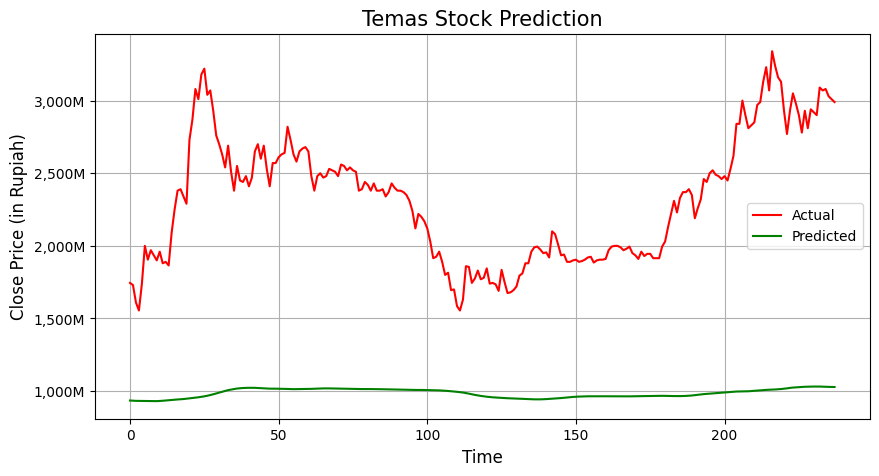

In [76]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_sigmoid_adamax.h5')

##### Tanh - Adam

In [77]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 16s 347ms/step - loss: 0.0024 - val_loss: 0.0061
Epoch 2/10
24/24 [==============================] - 7s 274ms/step - loss: 2.3202e-04 - val_loss: 0.0049
Epoch 3/10
24/24 [==============================] - 7s 288ms/step - loss: 1.5208e-04 - val_loss: 0.0046
Epoch 4/10
24/24 [==============================] - 7s 291ms/step - loss: 1.3957e-04 - val_loss: 0.0044
Epoch 5/10
24/24 [==============================] - 7s 278ms/step - loss: 1.3003e-04 - val_loss: 0.0041
Epoch 6/10
24/24 [==============================] - 7s 293ms/step - loss: 1.1603e-04 - val_loss: 0.0038
Epoch 7/10
24/24 [==============================] - 7s 287ms/step - loss: 1.1000e-04 - val_loss: 0.0039
Epoch 8/10
24/24 [==============================] - 7s 298ms/step - loss: 1.1227e-04 - val_loss: 0.0037
Epoch 9/10
24/24 [==============================] - 7s 287ms/step - loss: 1.0585e-04 - val_loss: 0.0034
Epoch 10/10
24/24 [==============================] - 7s 303ms/step 

In [78]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 68ms/step
Mean Absolute Percentage Error (MAPE):  0.09613
Mean Absolute Error (MAE):  0.1587229
Mean Squared Error (MSE):  0.0399889
Root Mean Squared Error (RMSE):  0.19997
R-Squared:  0.529644


8/8 [==============================] - 0s 50ms/step


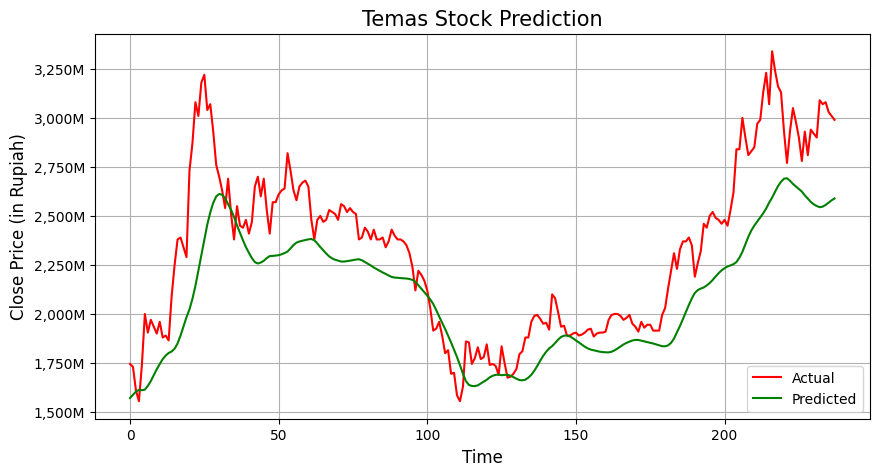

In [79]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_tanh_adam.h5')

##### Tanh - AdaGrad

In [80]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 15s 323ms/step - loss: 0.0096 - val_loss: 0.0871
Epoch 2/10
24/24 [==============================] - 6s 261ms/step - loss: 0.0063 - val_loss: 0.0798
Epoch 3/10
24/24 [==============================] - 6s 261ms/step - loss: 0.0059 - val_loss: 0.0769
Epoch 4/10
24/24 [==============================] - 7s 280ms/step - loss: 0.0058 - val_loss: 0.0759
Epoch 5/10
24/24 [==============================] - 7s 276ms/step - loss: 0.0057 - val_loss: 0.0748
Epoch 6/10
24/24 [==============================] - 7s 282ms/step - loss: 0.0057 - val_loss: 0.0741
Epoch 7/10
24/24 [==============================] - 7s 295ms/step - loss: 0.0056 - val_loss: 0.0733
Epoch 8/10
24/24 [==============================] - 7s 283ms/step - loss: 0.0055 - val_loss: 0.0725
Epoch 9/10
24/24 [==============================] - 7s 298ms/step - loss: 0.0054 - val_loss: 0.0718
Epoch 10/10
24/24 [==============================] - 7s 302ms/step - loss: 0.0054 - val_loss: 0.071

In [81]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Percentage Error (MAPE):  0.88792
Mean Absolute Error (MAE):  1.3759361
Mean Squared Error (MSE):  1.9757177
Root Mean Squared Error (RMSE):  1.4056
R-Squared:  -22.238705


8/8 [==============================] - 0s 43ms/step


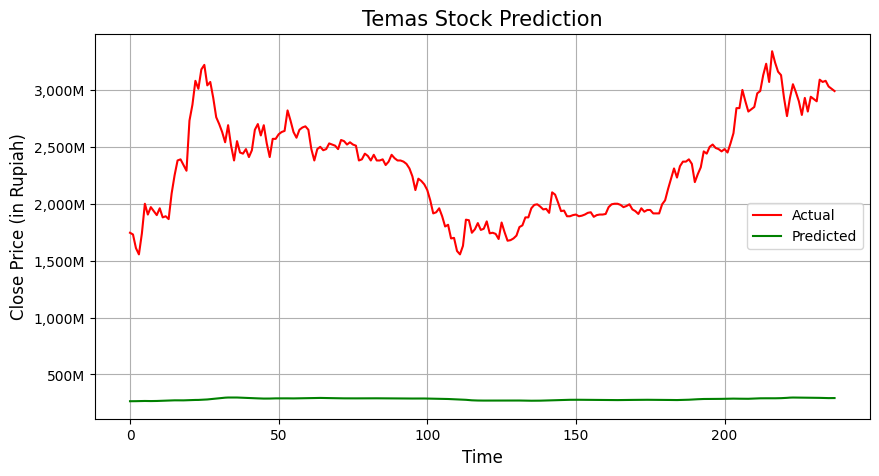

In [82]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_tanh_adagrad.h5')

##### Tanh - Nadam

In [83]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 18s 332ms/step - loss: 0.0018 - val_loss: 0.0066
Epoch 2/10
24/24 [==============================] - 7s 273ms/step - loss: 1.7676e-04 - val_loss: 0.0047
Epoch 3/10
24/24 [==============================] - 7s 281ms/step - loss: 1.4835e-04 - val_loss: 0.0043
Epoch 4/10
24/24 [==============================] - 7s 279ms/step - loss: 1.2445e-04 - val_loss: 0.0038
Epoch 5/10
24/24 [==============================] - 7s 280ms/step - loss: 1.1847e-04 - val_loss: 0.0035
Epoch 6/10
24/24 [==============================] - 8s 347ms/step - loss: 1.1210e-04 - val_loss: 0.0040
Epoch 7/10
24/24 [==============================] - 8s 333ms/step - loss: 1.1063e-04 - val_loss: 0.0039
Epoch 8/10
24/24 [==============================] - 7s 301ms/step - loss: 1.0172e-04 - val_loss: 0.0032
Epoch 9/10
24/24 [==============================] - 7s 296ms/step - loss: 1.0329e-04 - val_loss: 0.0037
Epoch 10/10
24/24 [==============================] - 7s 274ms/step 

In [84]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Percentage Error (MAPE):  0.16126
Mean Absolute Error (MAE):  0.2602408
Mean Squared Error (MSE):  0.0860038
Root Mean Squared Error (RMSE):  0.29326
R-Squared:  -0.01159


8/8 [==============================] - 0s 40ms/step


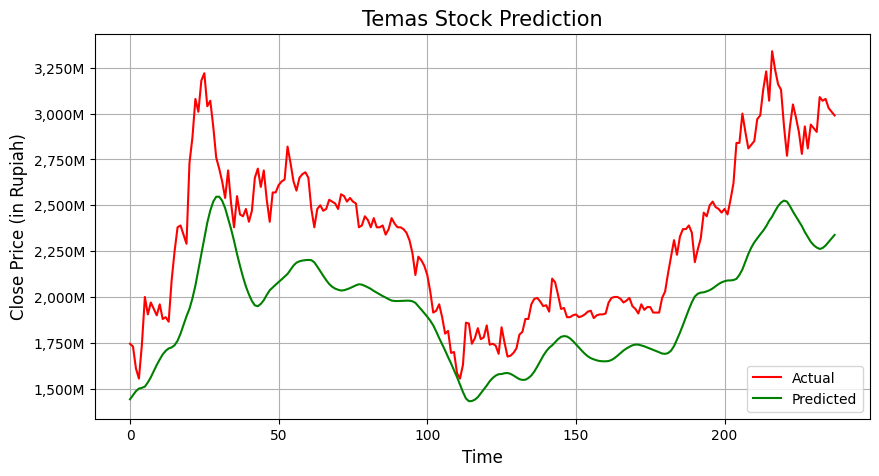

In [85]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_tanh_nadam.h5')

##### Tanh - RMSProp

In [86]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 14s 326ms/step - loss: 0.0018 - val_loss: 0.0077
Epoch 2/10
24/24 [==============================] - 6s 264ms/step - loss: 8.1232e-04 - val_loss: 0.0104
Epoch 3/10
24/24 [==============================] - 6s 271ms/step - loss: 5.1022e-04 - val_loss: 0.0110
Epoch 4/10
24/24 [==============================] - 7s 277ms/step - loss: 5.3726e-04 - val_loss: 0.0086
Epoch 5/10
24/24 [==============================] - 7s 272ms/step - loss: 4.8341e-04 - val_loss: 0.0103
Epoch 6/10
24/24 [==============================] - 7s 280ms/step - loss: 4.1970e-04 - val_loss: 0.0082
Epoch 7/10
24/24 [==============================] - 8s 324ms/step - loss: 4.1363e-04 - val_loss: 0.0072
Epoch 8/10
24/24 [==============================] - 6s 267ms/step - loss: 4.1177e-04 - val_loss: 0.0060
Epoch 9/10
24/24 [==============================] - 6s 270ms/step - loss: 3.0017e-04 - val_loss: 0.0056
Epoch 10/10
24/24 [==============================] - 7s 274ms/step 

In [87]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 38ms/step
Mean Absolute Percentage Error (MAPE):  0.19199
Mean Absolute Error (MAE):  0.3149178
Mean Squared Error (MSE):  0.129508
Root Mean Squared Error (RMSE):  0.35987
R-Squared:  -0.523294


8/8 [==============================] - 0s 40ms/step


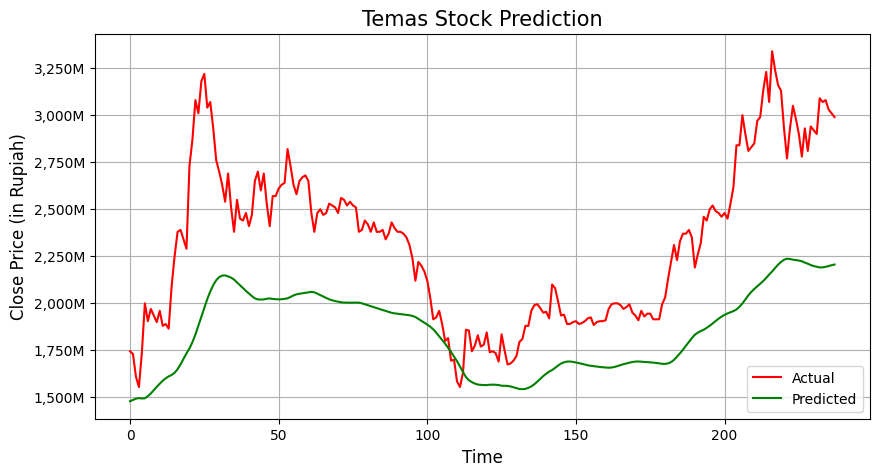

In [88]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_tanh_rmsprop.h5')

##### Tanh - AdaDelta

In [89]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 15s 318ms/step - loss: 0.0139 - val_loss: 0.1061
Epoch 2/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0137 - val_loss: 0.1054
Epoch 3/10
24/24 [==============================] - 6s 242ms/step - loss: 0.0135 - val_loss: 0.1047
Epoch 4/10
24/24 [==============================] - 6s 269ms/step - loss: 0.0134 - val_loss: 0.1040
Epoch 5/10
24/24 [==============================] - 7s 278ms/step - loss: 0.0131 - val_loss: 0.1032
Epoch 6/10
24/24 [==============================] - 6s 262ms/step - loss: 0.0128 - val_loss: 0.1025
Epoch 7/10
24/24 [==============================] - 6s 263ms/step - loss: 0.0127 - val_loss: 0.1018
Epoch 8/10
24/24 [==============================] - 6s 260ms/step - loss: 0.0126 - val_loss: 0.1011
Epoch 9/10
24/24 [==============================] - 6s 255ms/step - loss: 0.0123 - val_loss: 0.1004
Epoch 10/10
24/24 [==============================] - 6s 265ms/step - loss: 0.0121 - val_loss: 0.099

In [90]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 54ms/step
Mean Absolute Percentage Error (MAPE):  0.93285
Mean Absolute Error (MAE):  1.4423219
Mean Squared Error (MSE):  2.1612222
Root Mean Squared Error (RMSE):  1.47011
R-Squared:  -24.420639


8/8 [==============================] - 0s 47ms/step


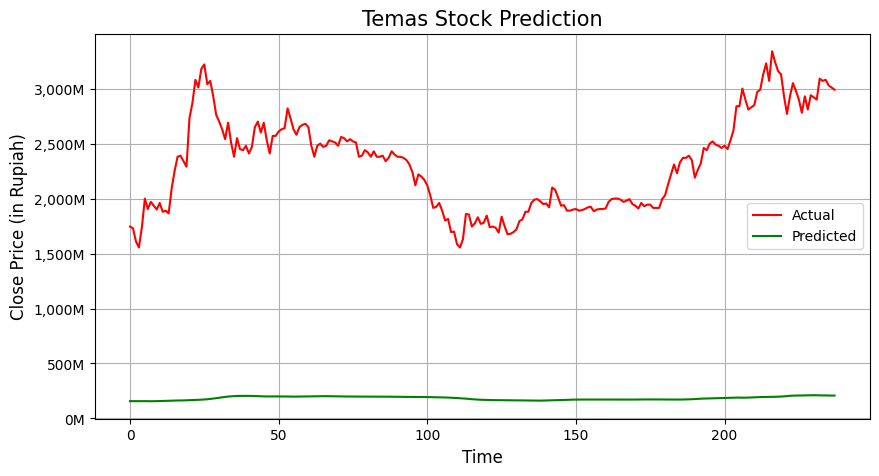

In [91]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_tanh_adadelta.h5')

##### Tanh - SGD

In [92]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 17s 368ms/step - loss: 0.0058 - val_loss: 0.0645
Epoch 2/10
24/24 [==============================] - 7s 280ms/step - loss: 0.0046 - val_loss: 0.0613
Epoch 3/10
24/24 [==============================] - 7s 288ms/step - loss: 0.0045 - val_loss: 0.0604
Epoch 4/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0043 - val_loss: 0.0595
Epoch 5/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0041 - val_loss: 0.0564
Epoch 6/10
24/24 [==============================] - 7s 283ms/step - loss: 0.0039 - val_loss: 0.0548
Epoch 7/10
24/24 [==============================] - 7s 283ms/step - loss: 0.0038 - val_loss: 0.0531
Epoch 8/10
24/24 [==============================] - 7s 291ms/step - loss: 0.0036 - val_loss: 0.0514
Epoch 9/10
24/24 [==============================] - 7s 286ms/step - loss: 0.0035 - val_loss: 0.0503
Epoch 10/10
24/24 [==============================] - 7s 298ms/step - loss: 0.0033 - val_loss: 0.048

In [93]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 51ms/step
Mean Absolute Percentage Error (MAPE):  0.71582
Mean Absolute Error (MAE):  1.113258
Mean Squared Error (MSE):  1.3044093
Root Mean Squared Error (RMSE):  1.14211
R-Squared:  -14.342669


8/8 [==============================] - 0s 47ms/step


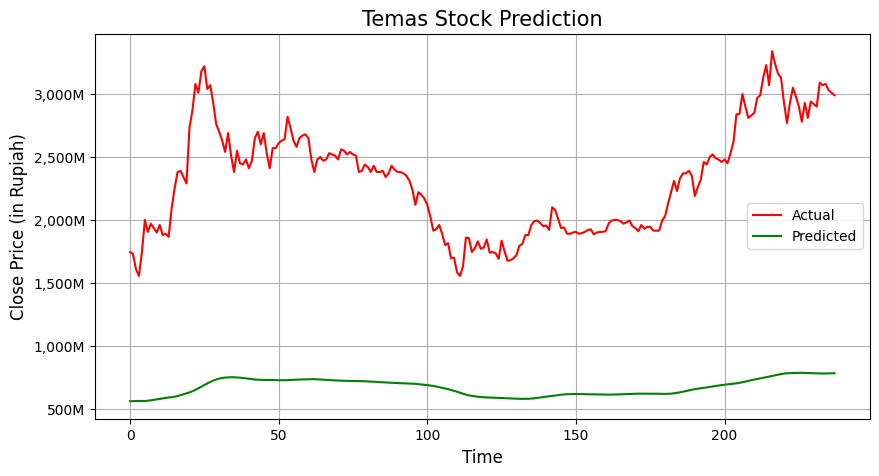

In [94]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_tanh_sgd.h5')

##### Tanh - Adamax

In [95]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 16s 322ms/step - loss: 0.0017 - val_loss: 0.0066
Epoch 2/10
24/24 [==============================] - 7s 286ms/step - loss: 2.4542e-04 - val_loss: 0.0074
Epoch 3/10
24/24 [==============================] - 7s 277ms/step - loss: 1.9406e-04 - val_loss: 0.0062
Epoch 4/10
24/24 [==============================] - 8s 316ms/step - loss: 1.8072e-04 - val_loss: 0.0060
Epoch 5/10
24/24 [==============================] - 8s 328ms/step - loss: 1.8101e-04 - val_loss: 0.0059
Epoch 6/10
24/24 [==============================] - 8s 324ms/step - loss: 1.6184e-04 - val_loss: 0.0059
Epoch 7/10
24/24 [==============================] - 6s 268ms/step - loss: 1.6303e-04 - val_loss: 0.0058
Epoch 8/10
24/24 [==============================] - 7s 273ms/step - loss: 1.4891e-04 - val_loss: 0.0058
Epoch 9/10
24/24 [==============================] - 6s 255ms/step - loss: 1.4825e-04 - val_loss: 0.0054
Epoch 10/10
24/24 [==============================] - 8s 349ms/step 

In [96]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 55ms/step
Mean Absolute Percentage Error (MAPE):  0.09045
Mean Absolute Error (MAE):  0.1490219
Mean Squared Error (MSE):  0.0383346
Root Mean Squared Error (RMSE):  0.19579
R-Squared:  0.549103


8/8 [==============================] - 0s 43ms/step


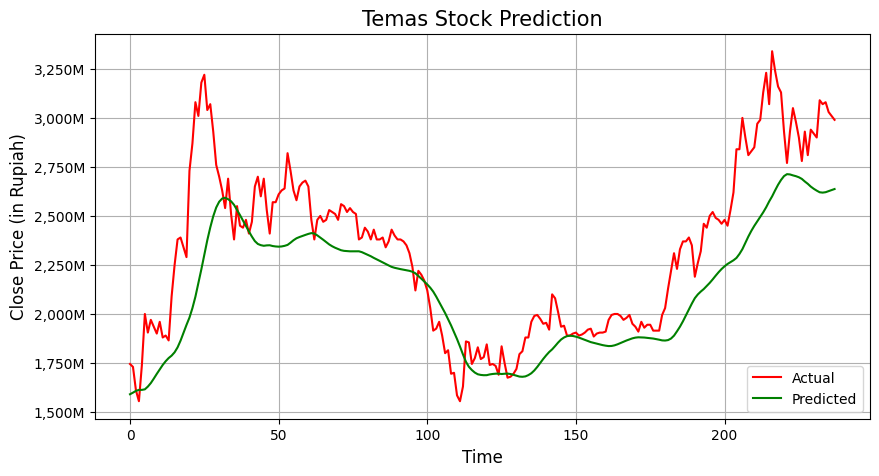

In [97]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Temas Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/tmas_tanh_adamax.h5')

##### Comparison LSTM Model based on Activation and Optimizer Parameter

In [98]:
# Define the activation functions and optimizers to be tested
activations = ['linear', 'relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'adagrad', 'nadam', 'rmsprop', 'adadelta', 'sgd', 'adamax']

# Generate all possible combinations of activation functions and optimizers
combinations = list(itertools.product(activations, optimizers))

# Define a function to build and train an LSTM model with a given activation function and optimizer
def build_model(activations, optimizers):
    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activations))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers)
    model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.1, verbose=0)
    return model

# Train and evaluate the models for all possible combinations of activation functions and optimizers
results = []
for activations, optimizers in combinations:
    print(f'Training model with {activations} activation and {optimizers} optimizer')
    start_time = time.time()
    model = build_model(activations, optimizers)
    end_time = time.time()
    preds = model.predict(X_test)
    mape = round(metrics.mean_absolute_percentage_error(y_test, preds), 5)
    mae = round(metrics.mean_absolute_error(y_test, preds), 5)
    mse = round(metrics.mean_squared_error(y_test, preds), 5)
    rmse = round(math.sqrt(mse), 5)
    r2 = round(metrics.r2_score(y_test, preds), 2)
    elapsed_time = round(end_time - start_time, 2)
    results.append([activations, optimizers, mape, mae, mse, rmse, r2, elapsed_time])

# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'], 
                                 index=['Activation', 'Optimizer'])

Training model with linear activation and adam optimizer
8/8 [==============================] - 2s 33ms/step
Training model with linear activation and adagrad optimizer
8/8 [==============================] - 2s 35ms/step
Training model with linear activation and nadam optimizer
8/8 [==============================] - 2s 35ms/step
Training model with linear activation and rmsprop optimizer
8/8 [==============================] - 3s 51ms/step
Training model with linear activation and adadelta optimizer
8/8 [==============================] - 2s 40ms/step
Training model with linear activation and sgd optimizer
8/8 [==============================] - 2s 38ms/step
Training model with linear activation and adamax optimizer
8/8 [==============================] - 2s 33ms/step
Training model with relu activation and adam optimizer
8/8 [==============================] - 1s 34ms/step
Training model with relu activation and adagrad optimizer
8/8 [==============================] - 2s 34ms/step
Training

In [99]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'], 
                                 index=['Activation', 'Optimizer'])
# Get several LSTM model evaluation 
df_pivot_result.sort_values(by=['Activation', 'Optimizer'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adadelta                69.94  1.55603   1.00817  2.50658   
           adagrad                 65.03  1.28934   0.83231  1.73406   
           adam                    71.96  0.16836   0.10380  0.04189   
           adamax                  73.34  0.13710   0.08378  0.03399   
           nadam                   70.01  0.22792   0.14232  0.06729   
           rmsprop                 76.78  0.31903   0.19517  0.13229   
           sgd                     69.70  1.30301   0.84060  1.77326   
relu       adadelta                62.70  1.39371   0.90185  2.01608   
           adagrad                 62.23  1.36764   0.88220  1.95360   
           adam                    64.16  0.23111   0.14279  0.07136   
           adamax                  71.94  0.17515   0.10628  0.04945   
           nadam                   70.07  0.26150   0.16457  0.08514   
           rmsprop                 70.12  0.31771   0.19362  0.13205   
           sgd                     62.66  1.45423   0.93871  2.20550   
sigmoid    adadelta                96.16  1.41901   0.91658  2.09721   
           adagrad                 89.72  1.36989   0.88336  1.96129   
           adam                    84.98  0.69456   0.43547  0.54509   
           adamax                 104.40  0.54437   0.33865  0.34560   
           nadam                   91.79  0.65218   0.40789  0.48513   
           rmsprop                 94.55  0.62980   0.39299  0.45579   
           sgd                     92.15  1.43366   0.92642  2.13893   
tanh       adadelta                82.74  1.54387   1.00058  2.46616   
           adagrad                 66.16  1.21566   0.78391  1.54512   
           adam                    66.41  0.21684   0.13309  0.06402   
           adamax                  91.39  0.18540   0.11251  0.05298   
           nadam                   80.51  0.22676   0.13999  0.06827   
           rmsprop                 88.63  0.29887   0.18164  0.11939   
           sgd                     90.91  1.24020   0.79968  1.60834   

                      R-Squared (%)  RMSE (%)  
Activation Optimizer                           
linear     adadelta          -28.48   1.58322  
           adagrad           -19.40   1.31684  
           adam                0.51   0.20467  
           adamax              0.60   0.18436  
           nadam               0.21   0.25940  
           rmsprop            -0.56   0.36372  
           sgd               -19.86   1.33164  
relu       adadelta          -22.71   1.41989  
           adagrad           -21.98   1.39771  
           adam                0.16   0.26713  
           adamax              0.42   0.22237  
           nadam               0.00   0.29179  
           rmsprop            -0.55   0.36339  
           sgd               -24.94   1.48509  
sigmoid    adadelta          -23.67   1.44817  
           adagrad           -22.07   1.40046  
           adam               -5.41   0.73830  
           adamax             -3.07   0.58788  
           nadam              -4.71   0.69651  
           rmsprop            -4.36   0.67512  
           sgd               -24.16   1.46251  
tanh       adadelta          -28.01   1.57040  
           adagrad           -17.17   1.24303  
           adam                0.25   0.25302  
           adamax              0.38   0.23017  
           nadam               0.20   0.26129  
           rmsprop            -0.40   0.34553  
           sgd               -17.92   1.26820

In [100]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'], 
                                 index=['Activation', 'Optimizer'])

# Calculate t-statistics and p-values for each performance metric
for col in ['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)']:
    t_stat, p_val = stats.ttest_1samp(df_result[col], 0.05)
    new_col_name_tstat = '{} (t-Statistic)'.format(col)
    new_col_name_pval = '{} (p-Value)'.format(col)
    df_pivot_result[new_col_name_tstat] = round(t_stat, 5)
    df_pivot_result[new_col_name_pval] = round(p_val, 5)

# Print the resulting pivot table with the horizontal t-statistic and p-value columns
df_pivot_result.sort_values(by=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'Elapsed Time (min)'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adamax                  73.34  0.13710   0.08378  0.03399   
           adam                    71.96  0.16836   0.10380  0.04189   
relu       adamax                  71.94  0.17515   0.10628  0.04945   
tanh       adamax                  91.39  0.18540   0.11251  0.05298   
           adam                    66.41  0.21684   0.13309  0.06402   
           nadam                   80.51  0.22676   0.13999  0.06827   
linear     nadam                   70.01  0.22792   0.14232  0.06729   
relu       adam                    64.16  0.23111   0.14279  0.07136   
           nadam                   70.07  0.26150   0.16457  0.08514   
tanh       rmsprop                 88.63  0.29887   0.18164  0.11939   
relu       rmsprop                 70.12  0.31771   0.19362  0.13205   
linear     rmsprop                 76.78  0.31903   0.19517  0.13229   
sigmoid    adamax                 104.40  0.54437   0.33865  0.34560   
           rmsprop                 94.55  0.62980   0.39299  0.45579   
           nadam                   91.79  0.65218   0.40789  0.48513   
           adam                    84.98  0.69456   0.43547  0.54509   
tanh       adagrad                 66.16  1.21566   0.78391  1.54512   
           sgd                     90.91  1.24020   0.79968  1.60834   
linear     adagrad                 65.03  1.28934   0.83231  1.73406   
           sgd                     69.70  1.30301   0.84060  1.77326   
relu       adagrad                 62.23  1.36764   0.88220  1.95360   
sigmoid    adagrad                 89.72  1.36989   0.88336  1.96129   
relu       adadelta                62.70  1.39371   0.90185  2.01608   
sigmoid    adadelta                96.16  1.41901   0.91658  2.09721   
           sgd                     92.15  1.43366   0.92642  2.13893   
relu       sgd                     62.66  1.45423   0.93871  2.20550   
tanh       adadelta                82.74  1.54387   1.00058  2.46616   
linear     adadelta                69.94  1.55603   1.00817  2.50658   

                      R-Squared (%)  RMSE (%)  MAPE (%) (t-Statistic)  \
Activation Optimizer                                                    
linear     adamax              0.60   0.18436                 6.59467   
           adam                0.51   0.20467                 6.59467   
relu       adamax              0.42   0.22237                 6.59467   
tanh       adamax              0.38   0.23017                 6.59467   
           adam                0.25   0.25302                 6.59467   
           nadam               0.20   0.26129                 6.59467   
linear     nadam               0.21   0.25940                 6.59467   
relu       adam                0.16   0.26713                 6.59467   
           nadam               0.00   0.29179                 6.59467   
tanh       rmsprop            -0.40   0.34553                 6.59467   
relu       rmsprop            -0.55   0.36339                 6.59467   
linear     rmsprop            -0.56   0.36372                 6.59467   
sigmoid    adamax             -3.07   0.58788                 6.59467   
           rmsprop            -4.36   0.67512                 6.59467   
           nadam              -4.71   0.69651                 6.59467   
           adam               -5.41   0.73830                 6.59467   
tanh       adagrad           -17.17   1.24303                 6.59467   
           sgd               -17.92   1.26820                 6.59467   
linear     adagrad           -19.40   1.31684                 6.59467   
           sgd               -19.86   1.33164                 6.59467   
relu       adagrad           -21.98   1.39771                 6.59467   
sigmoid    adagrad           -22.07   1.40046                 6.59467   
relu       adadelta          -22.71   1.41989                 6.59467   
sigmoid    adadelta          -23.67 

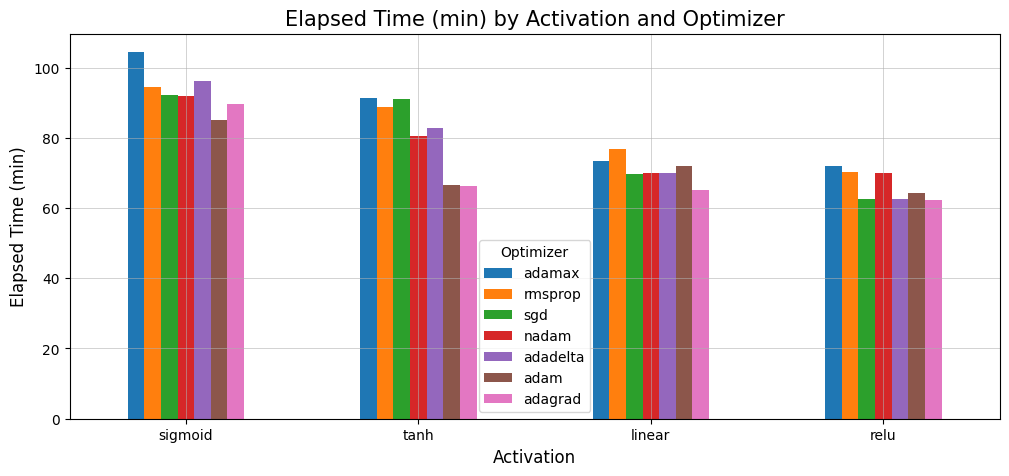

In [101]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_time = df_result.pivot_table(index='Activation', columns='Optimizer', values='Elapsed Time (min)')
# Sort the columns based on the mean elapsed time value
df_time = df_time[df_time.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_time = df_time.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean elapsed time value
df_time = df_time.sort_values(by=df_time.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_time.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Elapsed Time (min)', fontsize=12)
ax.set_title('Elapsed Time (min) by Activation and Optimizer', fontsize=15)
# formatter = ticker.PercentFormatter(xmax=1, decimals=0)
# ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

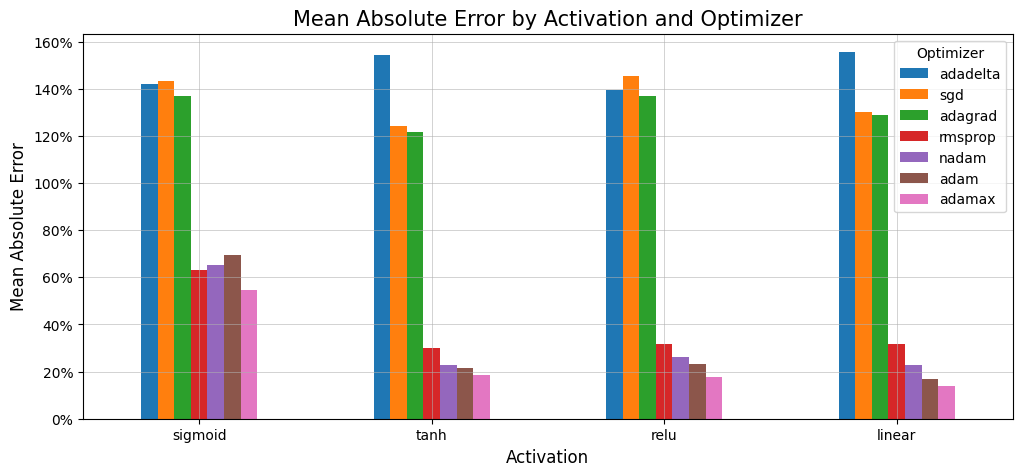

In [102]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mae = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAE (%)')
# Sort the columns based on the mean MAE value
df_mae = df_mae[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mae = df_mae.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean MAE value
df_mae = df_mae.sort_values(by=df_mae.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mae.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

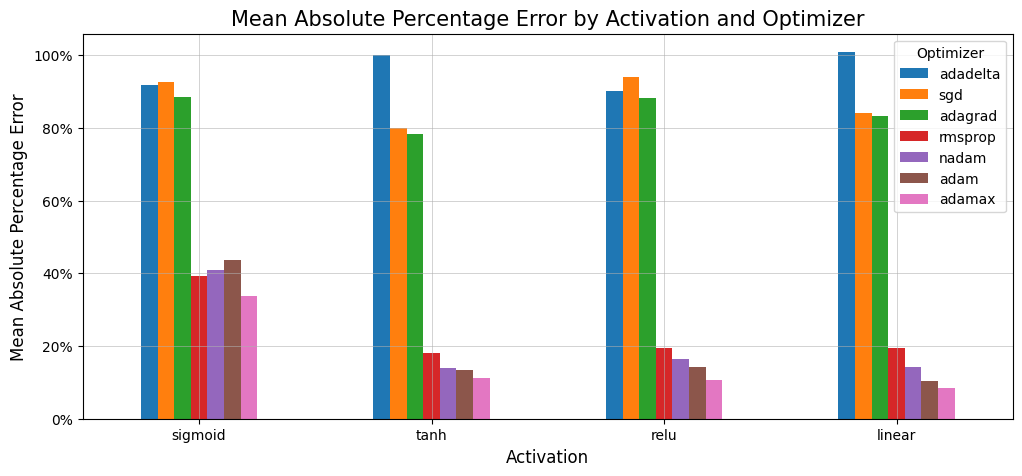

In [103]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mape = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAPE (%)')
# Sort the columns based on the mean MAPE value
df_mape = df_mape[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mape = df_mape.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean MAPE value
df_mape = df_mape.sort_values(by=df_mape.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mape.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Percentage Error', fontsize=12)
ax.set_title('Mean Absolute Percentage Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

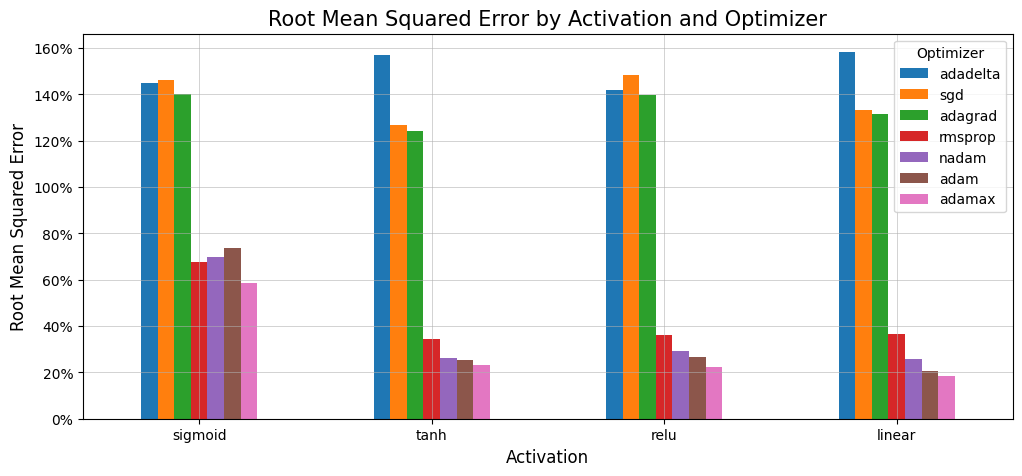

In [104]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_rmse = df_result.pivot_table(index='Activation', columns='Optimizer', values='RMSE (%)')
# Sort the columns based on the mean RMSE value
df_rmse = df_rmse[df_rmse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_rmse = df_rmse.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_rmse = df_rmse.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_rmse.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=12)
ax.set_title('Root Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

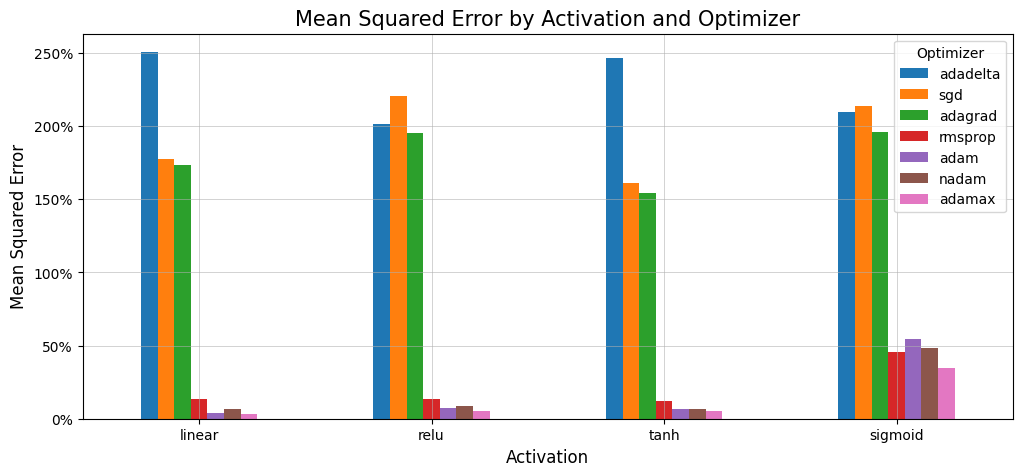

In [107]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mse = df_result.pivot_table(index='Activation', columns='Optimizer', values='MSE (%)')
# Sort the columns based on the mean RMSE value
df_mse = df_mse[df_mse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mse = df_mse.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_mse = df_mse.sort_values(by=df_mse.columns[-1], ascending=True)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mse.plot(kind='bar', ax=ax) # modified line
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Squared Error', fontsize=12) # modified line
ax.set_title('Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter) # modified line
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0) # modified line
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

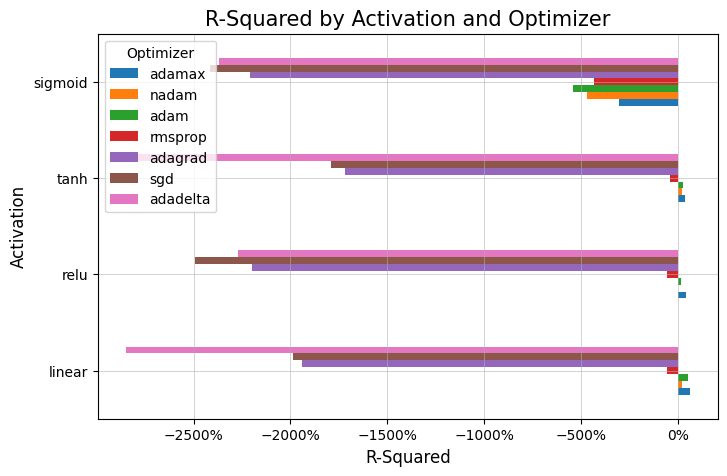

In [106]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_r2 = df_result.pivot_table(index='Activation', columns='Optimizer', values='R-Squared (%)')
# Sort the columns based on the mean RMSE value
df_r2 = df_r2[df_r2.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_r2 = df_r2.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_r2 = df_r2.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_r2.plot(kind='barh', ax=ax)
ax.set_xlabel('R-Squared', fontsize=12)
ax.set_ylabel('Activation', fontsize=12)
ax.set_title('R-Squared by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()